# Recurrent Neural Network


### From Assignment Brief:
The goal of this project is to build a next-word predictor, given a sequence of words. <br>
The input to your model is a sequence of words of any length (could be one word,
could be five words, etc.). <br>
The output of your model is a word that follows that sequence of words. <br>
In principle, given an input to your model, you can ask your model to predict the next
ten words, by asking your model to predict the next word ten times. <br>
To test your model, you must apply the following ten example sequences of words as inputs: <br>
You can ask your model to predict the next ten words, given each input. For example: (Seed text **bolded**) <br><br>
Model 1: <br>
**embrace each day** for morning's potential is a blank canvas seize it with <br>
**radiate some** gratitude and watch as the universe conspires to bring you <br>
**believe that** yourself and let your heart's whispers guide you to your <br>
**life's actual purpose is** a chance to learn to grow and to embrace the <br>
**dance through each and every** one chapter of life to the next world your nature <br>
**let your time and energy** so brightly that it eclipses even the darkest of days <br>
**every person is** of kindness sends ripples of positivity throughout the universe of <br>
**our country Singapore is** through storms knowing that your steps create the path to <br>
**planet earth is** through challenges like a breeze through the trees leaving a <br>
**morning and evening would make it** the chisels that sculpt you into a masterpiece of strength <br>

Model 2:<br>
**embrace each day** they bring the thunder that clears the path to your<br>
**radiate some** positivity illuminating the world with a light that banishes darkness<br>
**believe that** yourself and let your inner light outshine any darkness around<br>
**life's actual purpose is** a wildflower spreading love's fragrance far and wide and majesty<br>
**dance through each and every** from one chapter of life to the next next hues<br>
**let your time and energy** so hold mysteries waiting to be explored revealing hidden wonders<br>
**every person is** you nurture blooms into a garden of meaningful relationships relationships<br>
**our country Singapore is** is a testament to the city's ambition and resilience and<br>
**planet earth is** sparkles a reflection of the city's ambition to reach new<br>
**morning and evening would make it** a tapestry of flavors weaving a story of cultural fusion<br>

In [1]:
seed_texts = [
    'Embrace each day',
    'Radiate some',
    'Believe that',
    "Life's actual purpose is",
    'Dance through each and every',
    'Let your time and energy',
    'Every person is',
    'Our country Singapore is',
    'Planet earth is',
    'Morning and evening would make it'
]

In [2]:
import os
from tqdm.notebook import tqdm
import random
import warnings
import re

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Disable TF Warnings
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ["tf_gpu_allocator"]="cuda_malloc_async"
warnings.filterwarnings("ignore")

checkpoint_folder_path = "training_checkpoints/"

# example filepath large_weights.{epoch:02d}-{val_loss:.2f}.hdf5

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image

pd.set_option('display.max_colwidth', None)

import tensorflow as tf

print(tf.config.list_physical_devices('GPU'))
physical_devices = tf.config.experimental.list_physical_devices('GPU')

if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
!pip install rouge-metric

In [5]:
# import spacy

# nlp = spacy.load("en_core_web_sm")

from bert_score import score

import language_tool_python
tool = language_tool_python.LanguageTool('en-US')

from nltk.translate.bleu_score import sentence_bleu
# from nltk.translate.meteor_score import meteor_score
# from rouge_metric import PyRouge

In [6]:
!nvidia-smi

Sun Nov 26 01:42:18 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.06              Driver Version: 535.98       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4070        On  | 00000000:01:00.0  On |                  N/A |
|  0%   34C    P8               8W / 200W |   1841MiB / 12282MiB |      7%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [7]:
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Flatten, Dense, Dropout, ReLU, LeakyReLU, BatchNormalization, Add, Input, concatenate, TextVectorization, Embedding, Bidirectional, Attention, GaussianNoise
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, SimpleRNNCell, StackedRNNCells, LSTMCell, GRUCell, RNN
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

In [8]:
import visualkeras

In [9]:
sns.set(style='darkgrid', palette='deep')

tf.random.set_seed(42)
random.seed(42)

# Exploratory Data Analysis

The dataset consists of 1000 training text samples.

In [10]:
df = pd.read_csv("data/train.csv")
eda_df = df.copy()

In [11]:
eda_df.head()

,Quotes
0,Embrace the beauty of every sunrise; it's a fresh chance to paint your world with joy.
1,Embrace challenges; they are the stepping stones to your greatest victories.
2,Embrace the rhythm of life and let it dance through your soul.
3,"Embrace kindness, for it has the power to change the world one heart at a time."
4,"Embrace the journey, for it leads to the destination of your dreams."


In [12]:
eda_df.describe()

,Quotes
count,1000
unique,890
top,"Radiate acceptance, and find peace in embracing what is."
freq,5


there are some repeated sentences which have to be removed

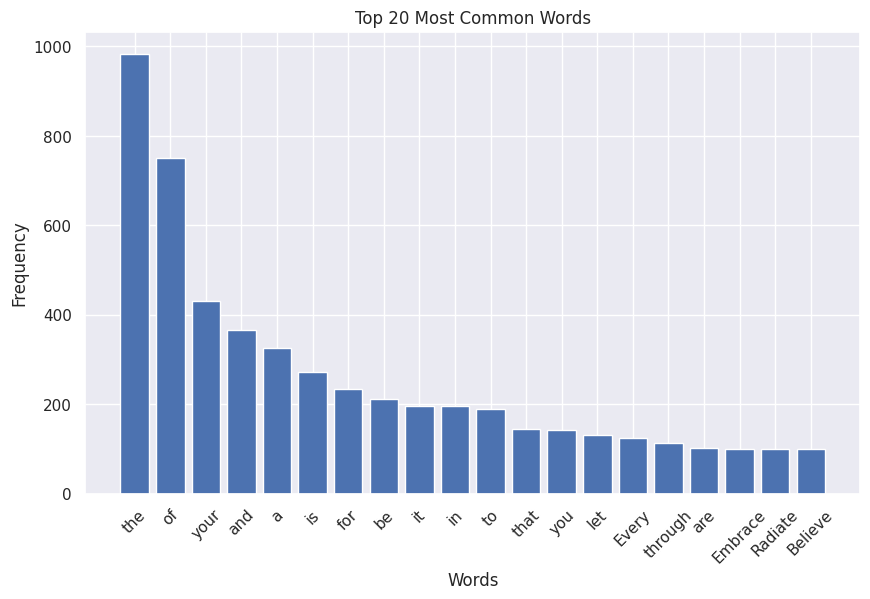

In [13]:
from collections import Counter

# Assuming 'sentences' is a list of sentences in your dataset
words = [word for sentence in eda_df["Quotes"] for word in sentence.split()]
word_freq = Counter(words)
top_20_words = dict(word_freq.most_common(20))

plt.figure(figsize=(10, 6))
plt.bar(top_20_words.keys(), top_20_words.values())
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 20 Most Common Words')
plt.xticks(rotation=45)
plt.show()

In [14]:
sentence_lengths = [len(sentence.split()) for sentence in eda_df["Quotes"]]
print("Average sentence length:", sum(sentence_lengths) / len(sentence_lengths))
print("Maximum sentence length:", max(sentence_lengths))
print("Minimum sentence length:", min(sentence_lengths))

Average sentence length: 11.865
Maximum sentence length: 35
Minimum sentence length: 7


## Preprocessing

In [15]:
all_sentences = df["Quotes"].unique()

In [16]:
train, test = train_test_split(all_sentences, test_size=0.1, random_state=23)
train, validation = train_test_split(train, test_size=1/9, random_state=23)

In [17]:
all_sentences

array(["Embrace the beauty of every sunrise; it's a fresh chance to paint your world with joy.",
       'Embrace challenges; they are the stepping stones to your greatest victories.',
       'Embrace the rhythm of life and let it dance through your soul.',
       'Embrace kindness, for it has the power to change the world one heart at a time.',
       'Embrace the journey, for it leads to the destination of your dreams.',
       'Embrace your uniqueness, for it is the fingerprint of your soul on the universe.',
       'Embrace the present moment, for it is the only one that truly exists.',
       'Embrace your fears, for they hold the key to unlocking your true potential.',
       'Embrace gratitude, and watch how it multiplies the blessings in your life.',
       'Embrace the rain, for it nourishes the seeds of your future success.',
       'Embrace the whispers of your heart; they carry the wisdom of the universe.',
       'Embrace laughter, for it is the music of a joyful heart.',
 

In [18]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [19]:
import re

contractions = {
    "'s": "is",
    "'ve": "have",
    "'ll": "will"
}

def tokenize_regex(sentence, remove_spaces=True, replace_contraction=False):
    if remove_spaces:
        pattern = f'[{re.escape(string.punctuation)}]'
        split_result_spaces = re.split(f'({pattern})', sentence)
        split_result = []
        for res in split_result_spaces:
            split_result += res.split(" ")
    else:
        pattern = f'[{re.escape(string.punctuation)} ]'
        split_result = re.split(f'({pattern})', sentence)

    result = [s for s in split_result if s]

    for i in range(len(result)-1, 0, -1):
        if contractions.get(result[i-1]+result[i]):
            if replace_contraction:
                result[i-1] = contractions.get(result[i-1]+result[i])
            else:
                result[i-1] = result[i-1]+result[i]
            result.pop(i)

    return result

sentence = "Embrace the beauty of every sunrise; it's a fresh chance to paint your world with joy."
result = tokenize_regex(sentence)
print(result)

['Embrace', 'the', 'beauty', 'of', 'every', 'sunrise', ';', 'it', "'s", 'a', 'fresh', 'chance', 'to', 'paint', 'your', 'world', 'with', 'joy', '.']


In [20]:
def remove_punctuation(sentence):
    PUNC = [";", ".", ",", ":", "?", "!", "\n", "\t", "'", '"', "-"]
    output = []
    for word in sentence:
        if word not in PUNC:
            output.append(word)
    return output

# def keep_joint(sentence, joiner):
#     output = [sentence[0]]
#     for i, word in enumerate(sentence[1:]):
#         if joiner in word:
#             output.pop()
#             output.append(sentence[i-1]+word)
#             print(i, sentence)
#         else:
#             output.append(word)
#     return output

def lower_case(sentence):
    output = []
    for word in sentence:
        output.append(word.lower())
    return output

# def remove_contractions(sentence):
#     contractions = {
#         "'s": "is",
#         "'ve": "have",
#         "'ll": "will"
#     }
#     output = []
#     for word in sentence:
#         if word in contractions:
#             word = contractions[word]
#         output.append(word)
#     # print(output)
#     return output

def clean_sentences(sentences):
    for i, sentence in enumerate(sentences):
        sentences[i] = lower_case(remove_punctuation(sentence))
        # sentences[i] = lower_case(sentence)
        # sentences[i] = remove_contractions(sentence)
        # sentences[i] = keep_joint(sentences[i], "-")
    return sentences

def clean_sentences_for_input(sentences):
    for i, sentence in enumerate(sentences):
        sentences[i] = lower_case(sentence)
    #     sentences[i] = remove_contractions(sentence)
    #     # sentences[i] = keep_joint(sentences[i], "-")
    return sentences

In [21]:
tokenized_quotes = [tokenize_regex(sentence) for sentence in all_sentences]
tokenized_quotes = clean_sentences(tokenized_quotes)

In [22]:
all_words = []

for word in tokenized_quotes:
    all_words += word
    
print(f"Total word count: {len(all_words)}")

# for word in lemmatized_quotes:
#     all_words += word

all_words = list(set(all_words))

Total word count: 10926


In [23]:
for i in range(5):
    print(tokenized_quotes[i])

# for i in range(5):
#     print(lemmatized_quotes[i])
    
tokenizer = Tokenizer(split=" ", lower=True)
tokenizer.fit_on_texts([all_words])

total_words = len(tokenizer.word_index)
print(f"Number of unique words: {total_words}")
total_words += 1

max_sequence_length = 35

['embrace', 'the', 'beauty', 'of', 'every', 'sunrise', 'it', "'s", 'a', 'fresh', 'chance', 'to', 'paint', 'your', 'world', 'with', 'joy']
['embrace', 'challenges', 'they', 'are', 'the', 'stepping', 'stones', 'to', 'your', 'greatest', 'victories']
['embrace', 'the', 'rhythm', 'of', 'life', 'and', 'let', 'it', 'dance', 'through', 'your', 'soul']
['embrace', 'kindness', 'for', 'it', 'has', 'the', 'power', 'to', 'change', 'the', 'world', 'one', 'heart', 'at', 'a', 'time']
['embrace', 'the', 'journey', 'for', 'it', 'leads', 'to', 'the', 'destination', 'of', 'your', 'dreams']
Number of unique words: 1181


In [24]:
def sentences_to_data(sentences, min_len, AorB, max_len=100, tokenize=True, verbose=0):
    # X_lemma = []
    X_word = []
    y = []

    tokenized_input = [tokenize_regex(sentence) for sentence in sentences]
    tokenized_input = clean_sentences(tokenized_input)
    
    # min_sequence_length = 4
    # max_sequence_length = 25
    if AorB:
        for sequence in tokenized_input:
            for i in range(len(sequence)):
                for j in range(i+min_len, len(sequence) if len(sequence) < i+max_len else i+max_len):
                    # X_lemma.append(" ".join(sequence[i:j]))
                    X_word.append(" ".join(sequence[i:j]))
                    y.append(sequence[j])
                    if verbose > 0:
                        if len(tokenizer.texts_to_sequences([y[-1]])[0]) != 1:
                            print(y[-1])
    else:
        for sequence in tokenized_input:
            for i in range(min_len, len(sequence) if len(sequence) < max_len else max_len):
                X_word.append(" ".join(sequence[:i]))
                y.append(sequence[i])
                if verbose > 0:
                    if len(tokenizer.texts_to_sequences([y[-1]])[0]) != 1:
                        print(y[-1])

    sentence_lengths = [len(sentence.split(" ")) for sentence in sentences]
    if verbose > 0:
        print("Average sentence length:", sum(sentence_lengths) / len(sentence_lengths))
        print("Maximum sentence length:", max(sentence_lengths))
        print("Longest sentence: ", X_word[np.argmax(sentence_lengths)])
        print("Minimum sentence length:", min(sentence_lengths))

    if tokenize:
        X_word = tokenizer.texts_to_sequences(X_word)
        X_word = pad_sequences(X_word, maxlen=max_sequence_length, padding="pre")
    else:
        X_word = clean_sentences_for_input([sentence.split(" ") for sentence in X_word])
        X_word = [" ".join(sentence) for sentence in X_word]

    y = tokenizer.texts_to_sequences(y)
    
    if verbose > 0:
        for pred, label in zip(X_word[:5], y[:5]):
            print(f"Predictor: {pred}\nLabel: {label}")
    
    y = to_categorical(y, num_classes=total_words)
    y = y.astype(float)
    y = np.array(y)

    X_word = np.array(X_word)

    if verbose > 0:
        print(X_word.shape, y.shape)

    return X_word, y

In [25]:
def fit_model(model, filepath, batch_size=32, epochs=20, callbacks=[]):
    # cp_callback = ModelCheckpoint(filepath=filepath, save_format='tf', save_weights_only=True, save_best_only=True, verbose=1, save_freq='epoch')
    
    history = model.fit(
        X_train, 
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_validation, y_validation),
        callbacks=[] + callbacks
    )
    
    accuracy = model.evaluate(X_test, y_test, verbose=0)[1]
    
    print(f"Accuracy: {accuracy:.2f}")

    return history

def plot_history(fit_history, title, savefig=""):
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    fig.suptitle(title)
    
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Accuracy')
    
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    
    left_legend = []
    for k, v in fit_history.items():
        ax[0].plot(v.history['accuracy'])
        ax[0].plot(v.history['val_accuracy'])
        left_legend += [f'{k} Train', f'{k} Validation']
    ax[0].legend(left_legend, loc='lower right')
    
    right_legend = []
    for k, v in fit_history.items():
        ax[1].plot(v.history['loss'])
        ax[1].plot(v.history['val_loss'])
        right_legend += [f'{k} Train', f'{k} Validation']
    ax[1].legend(right_legend, loc='upper right')
    
    plt.tight_layout()

    if savefig != "":
        fig.savefig(savefig, bbox_inches='tight')
    plt.show()

def joining_with_contractions(tokens):
    output = tokens[0]
    for token in tokens[1:]:
        if token not in contractions.keys():
            output += " "
        output += token
    return output

def predict_next_word(model, seed_text, next_words=1):
    for _ in range(next_words):
        seed_text = clean_sentences([tokenize_regex(seed_text)])[0]
        seed_text = " ".join(seed_text)
        
        # token_list = tokenizer.texts_to_sequences([seed_text])[0]
        # token_list = pad_sequences([token_list], maxlen=max_sequence_length, padding='pre')
        model_prediction = model.predict([seed_text], verbose=0)
        predicted_index = np.argmax(model_prediction, axis=-1)
        predicted_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted_index:
                predicted_word = word
                break
        
        space = "" if predicted_word in contractions.keys() else " "
        seed_text += space + predicted_word
        seed_text = clean_sentences([tokenize_regex(seed_text)])[0]
        seed_text = joining_with_contractions(seed_text)
    return seed_text

def sample_with_temperature(probs, temperature=1.0):
    if temperature == 0:
        sampled_index = np.argmax(probs)
    else:
        # Adjust probabilities with temperature
        probs = np.power(probs, 1.0 / temperature)
        probs /= np.sum(probs)

    # print(probs)
    # Sample a word
        sampled_index = np.random.choice(len(probs), p=probs)

    # print(sampled_index)
    return sampled_index

def predict_next_word_temperature(model, seed_text, temperature, next_words=1):
    for _ in range(next_words):
        seed_text = clean_sentences([tokenize_regex(seed_text)])[0]
        seed_text = " ".join(seed_text)
        
        model_prediction = model.predict([seed_text], verbose=0)

        # print(np.array(model_prediction).shape)
        predicted_index = [sample_with_temperature(x/sum(x), temperature) for x in model_prediction][0]
        
        # predicted_index = sample_with_temperature(model_prediction, temperature)
        predicted_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted_index:
                predicted_word = word
                break
        seed_text += " " + predicted_word
        seed_text = clean_sentences([tokenize_regex(seed_text)])[0]
        seed_text = joining_with_contractions(seed_text)
    return seed_text


In [26]:
# # predict_next_word_temperature

# # for seed_text in seed_texts:
# #     predicted_text = predict_next_word(simple_GRU_B, seed_text, next_words=10)
# #     print(predicted_text)
# print("Temperature: 0")

# for seed_text in seed_texts:
#     predicted_text = predict_next_word_temperature(simple_GRU_B, seed_text, 0, next_words=10)
#     print(predicted_text)

# print("Temperature: 1")

# for seed_text in seed_texts:
#     predicted_text = predict_next_word_temperature(simple_GRU_B, seed_text, 1, next_words=10)
#     print(predicted_text)

### TextVectorization

In [27]:
random.seed(42)

X_train, y_train = sentences_to_data(train, 2, True, tokenize=False, verbose=1)
X_test, y_test = sentences_to_data(test, 2, False, tokenize=False, verbose=1)
X_validation, y_validation = sentences_to_data(validation, 2, False, tokenize=False, verbose=1)

temp = list(zip(X_train, y_train))
random.shuffle(temp)
X_train, y_train = zip(*temp)
X_train = np.array(X_train)
y_train = np.array(y_train)

temp = list(zip(X_validation, y_validation))
random.shuffle(temp)
X_validation, y_validation = zip(*temp)
X_validation = np.array(X_validation)
y_validation = np.array(y_validation)

temp = list(zip(X_test, y_test))
random.shuffle(temp)
X_test, y_test = zip(*temp)
X_test = np.array(X_test)
y_test = np.array(y_test)

Average sentence length: 11.85252808988764
Maximum sentence length: 34
Longest sentence:  let your smile be the compass
Minimum sentence length: 7
Predictor: this morning
Label: [987]
Predictor: this morning let
Label: [104]
Predictor: this morning let your
Label: [1008]
Predictor: this morning let your smile
Label: [224]
Predictor: this morning let your smile be
Label: [868]
(43962,) (43962, 1182)
Average sentence length: 12.089887640449438
Maximum sentence length: 35
Longest sentence:  dance through the canvas of your
Minimum sentence length: 7
Predictor: our planet
Label: [587]
Predictor: our planet 's
Label: [573]
Predictor: our planet 's archipelagos
Label: [881]
Predictor: our planet 's archipelagos are
Label: [868]
Predictor: our planet 's archipelagos are the
Label: [1137]
(929,) (929, 1182)
Average sentence length: 12.191011235955056
Maximum sentence length: 33
Longest sentence:  this morning let your actions be a symphony of compassion love and kindness that
Minimum sentence 

In [28]:
max_vocab_size = 10000

vectorize_layer = TextVectorization(
    max_tokens=max_vocab_size,
    output_mode='int',
    output_sequence_length=35,
    # ngrams=5
)

vectorize_layer.adapt([" ".join(x) for x in clean_sentences_for_input(tokenized_quotes)])

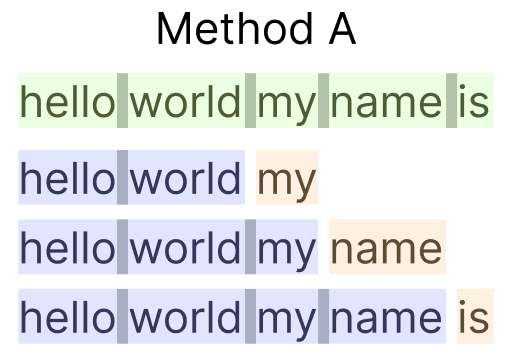

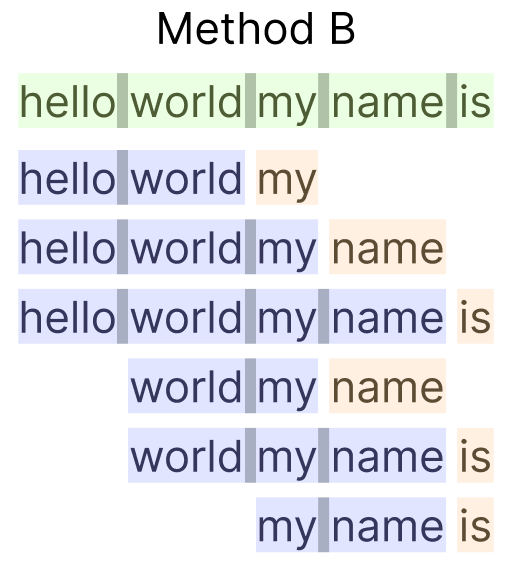

In [29]:
display(Image("images/Method A.png"))
display(Image("images/Method B.png"))

**Legend**
* Green is the original text
* Blue becomes the `X`
* Orange becomes the `y`

Method A is a more direct approach and mirrors the target task, where the predicted word is recursively added to the seed text. <br>
Method B extends this idea by creating the `X` starting from subsequent words in the original text. This creates much more data for the models to work with and I think this could help capture the word-to-word relationships better.

For both method A and B I will test and validate on method A, since that is reflective of the final word prediction task.

In [34]:
# Method A

simple_GRU_A = Sequential([
    vectorize_layer,
    Embedding(total_words, 768, mask_zero=True),
    GRU(64),
    Dense(total_words, activation='softmax')
])
simple_GRU_A.compile(loss='categorical_crossentropy', optimizer=Adam(clipnorm=1), metrics=['accuracy'])

prepro_methods = {}

# min length 2
X_train, y_train = sentences_to_data(train, 2, False, tokenize=False, verbose=0)
X_test, y_test = sentences_to_data(test, 2, False, tokenize=False, verbose=0)
X_validation, y_validation = sentences_to_data(validation, 2, False, tokenize=False, verbose=0)

temp = list(zip(X_train, y_train))
random.shuffle(temp)
X_train, y_train = zip(*temp)
X_train = np.array(X_train)
y_train = np.array(y_train)

prepro_methods["A"] = fit_model(simple_GRU_A, "", batch_size=32, epochs=50)
simple_GRU_A.save("models/GRU_A.keras")

# Method B

simple_GRU_B = Sequential([
    vectorize_layer,
    Embedding(total_words, 768, mask_zero=True),
    GRU(64),
    Dense(total_words, activation='softmax')
])
simple_GRU_B.compile(loss='categorical_crossentropy', optimizer=Adam(clipnorm=1), metrics=['accuracy'])

X_train, y_train = sentences_to_data(train, 2, True, tokenize=False, verbose=0)
# X_test, y_test = sentences_to_data(test, 2, True, tokenize=False, verbose=0)
# X_validation, y_validation = sentences_to_data(validation, 2, True, tokenize=False, verbose=0)

temp = list(zip(X_train, y_train))
random.shuffle(temp)
X_train, y_train = zip(*temp)
X_train = np.array(X_train)
y_train = np.array(y_train)

simple_GRU_B.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
prepro_methods["B"] = fit_model(simple_GRU_B, "", batch_size=32, epochs=50)
simple_GRU_B.save("models/GRU_B.keras")

Epoch 1/50


KeyboardInterrupt: 

In [341]:
simple_GRU_B_256bs = Sequential([
    vectorize_layer,
    Embedding(total_words, 768, mask_zero=True),
    GRU(64),
    Dense(total_words, activation='softmax')
])
simple_GRU_B_256bs.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
prepro_methods["B_256_bs"] = fit_model(simple_GRU_B_256bs, "", batch_size=256, epochs=50)
simple_GRU_B_256bs.save("models/GRU_B_256bs.keras")

Epoch 1/50
172/172 [==============================] - 8s 34ms/step - loss: 5.5797 - accuracy: 0.1172 - val_loss: 5.1624 - val_accuracy: 0.1558
Epoch 2/50
172/172 [==============================] - 4s 22ms/step - loss: 4.3073 - accuracy: 0.2446 - val_loss: 4.3010 - val_accuracy: 0.2956
Epoch 3/50
172/172 [==============================] - 3s 19ms/step - loss: 3.3968 - accuracy: 0.3704 - val_loss: 3.9193 - val_accuracy: 0.3693
Epoch 4/50
172/172 [==============================] - 3s 19ms/step - loss: 2.8536 - accuracy: 0.4326 - val_loss: 3.7308 - val_accuracy: 0.3863
Epoch 5/50
172/172 [==============================] - 3s 18ms/step - loss: 2.4583 - accuracy: 0.4801 - val_loss: 3.6338 - val_accuracy: 0.3949
Epoch 6/50
172/172 [==============================] - 3s 18ms/step - loss: 2.1456 - accuracy: 0.5288 - val_loss: 3.5817 - val_accuracy: 0.4152
Epoch 7/50
172/172 [==============================] - 3s 19ms/step - loss: 1.8967 - accuracy: 0.5766 - val_loss: 3.5620 - val_accuracy: 0.4237

In [35]:
simple_GRU_A = load_model('models/GRU_A.keras')
simple_GRU_B = load_model('models/GRU_B.keras')
simple_GRU_B_256bs = load_model('models/GRU_B_256bs.keras')

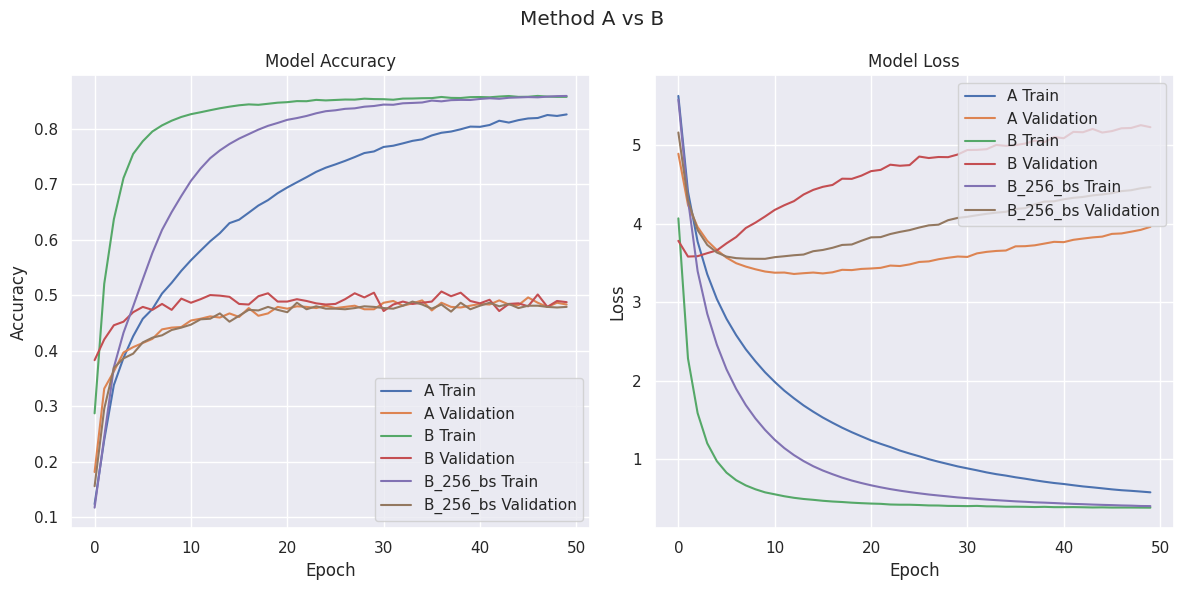

In [342]:
plot_history(prepro_methods, title="Method A vs B")

In [30]:
def eval_different_length_test(model, min_len=2, max_len=12):
    y = []
    for i in range(min_len, max_len+1):
    
        X_test, y_test = sentences_to_data(test, i, False, max_len=i+1, tokenize=False, verbose=0)
        
        accuracy = model.evaluate(X_test, y_test, verbose=0)[1]

        y.append(accuracy)
    return list(range(min_len, max_len+1)), y

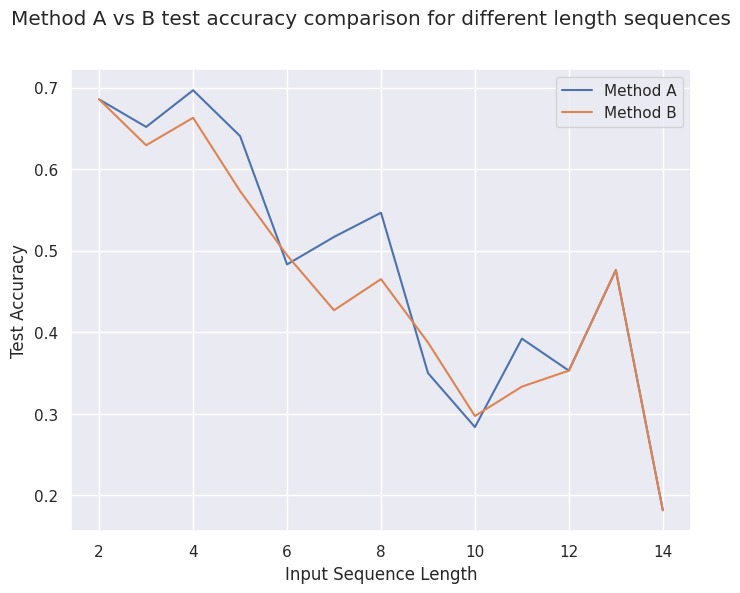

In [344]:
plt.figure(figsize=(8, 6))

x, y = eval_different_length_test(simple_GRU_A, max_len=14)
axA = sns.lineplot(x=x, y=y, label="Method A")

x, y = eval_different_length_test(simple_GRU_B_256bs, max_len=14)
axB = sns.lineplot(x=x, y=y, label="Method B")

# plt.legend(["Method A", "Method B"])
plt.legend()
plt.ylabel("Test Accuracy")
plt.xlabel("Input Sequence Length")
plt.suptitle("Method A vs B test accuracy comparison for different length sequences")

plt.show()

In [31]:
def objective_task(model, seed_texts=seed_texts, temperature=0):
    output_text = []
    for seed_text in tqdm(seed_texts):
        output_text.append(predict_next_word_temperature(model, seed_text, temperature, next_words=10))
    return output_text

In [346]:
predicted_text_A = objective_task(simple_GRU_A)
predicted_text_A

  0%|          | 0/10 [00:00<?, ?it/s]

['embrace each day with a heart full of gratitude for it nurtures your',
 'radiate some and let it be the foundation of your strength and',
 'believe that words and heart this morning let your heart be the',
 "life's actual purpose is a gift to everyone you meet around you meet has",
 'dance through each and every moment of the heart spreading warmth and happiness far and',
 'let your time and energy will lift you up even the simplest moments into treasures',
 'every person is the heartbeat of a grateful heart for it is the',
 'our country singapore is every step taken in faith is a step towards witnessing',
 'planet earth is a gesture of hope for they hold the promise of',
 "morning and evening would make it knows no limits limits to labrador park's ruggedness singapore"]

In [347]:
predicted_text_B = objective_task(simple_GRU_B_256bs)
predicted_text_B

  0%|          | 0/10 [00:00<?, ?it/s]

['embrace each day with a heart full of gratitude for it is the',
 'radiate some and let it be the beacon of your strength and',
 'believe that propels you forward is a symphony a symphony of joy',
 "life's actual purpose is a gift that keeps on giving heartbeats in arid landscapes",
 'dance through each and every day is a gift a gift from the universe a',
 'let your time and energy will follow an opportunity for growth and learning for it',
 'every person is you stronger than your fears and you will be a',
 'our country singapore is rich with the fruits of love and joy will follow',
 "planet earth is progress our planet's future are the nurseries of biodiversity",
 'morning and evening would make it knows the path to true happiness far and wide in']

* Both methods are comparable in their final results, however method B seems to improve much faster than method A.
* The comparison for test accuracy of sequences of different lengths shows that method B generally performs better.
* Both methods plateau at around 0.47 validation accuracy, while there is an inflection point where validation loss begins to increase for both.

Some sequences of words repeated in the dataset can be followed by various different words, which may be part of the reason why the probability is high for a large number of words.

## Evaluating Grammar

In [32]:
def check_grammar(text):
    return tool.check(text)

def score_grammar(texts):
    grammar_score = 0
    mistakes = []
    for text in texts:
        mistakes.append(check_grammar(text))
    for mistakeses in mistakes:
        for mistake in mistakeses:
            if mistake.ruleId != "MORFOLOGIK_RULE_EN_US" and mistake.ruleId != "UPPERCASE_SENTENCE_START":
                grammar_score += 1
    grammar_score /= len(texts)
    return grammar_score, mistakes

In [349]:
print(f"Method A average number of mistakes : {score_grammar(predicted_text_A)[0]}")
print(f"Method B average number of mistakes : {score_grammar(predicted_text_B)[0]}")

Method A average number of mistakes : 0.1
Method B average number of mistakes : 0.3


In [350]:
print(f"Average number of mistakes in the given dataset: {score_grammar(all_sentences)[0]}")

Average number of mistakes in the given dataset: 0.0056179775280898875


In [351]:
test[:10]

array(["Our planet's archipelagos are the jewels set in the crown of the sea.",
       'Believe in yourself, and you will be a beacon of light for others.',
       'Believe in yourself, and you will make a difference.',
       'Every sunset is a reminder of the beauty in letting go.',
       'Every act of empathy is a bridge that connects souls.',
       'Dance through the canvas of your destiny, painting it with intention and love.',
       'Radiate determination, and let it be the fuel that powers your journey.',
       'With the rising sun, let gratitude fill every corner of your heart this morning.',
       "From Singapore Zoo's wonders to River Safari's adventures, Singapore's wildlife is a treasure.",
       'Every act of conservation is a vote for the future of our planet.'],
      dtype=object)

In [352]:
test_seed_texts = []
for sentence in test:
    test_seed_texts.append(" ".join(tokenize_regex(sentence)[:2]))
test_seed_texts = list(set(test_seed_texts))

In [328]:
predicted_test_text_A = objective_task(simple_GRU_A, seed_texts=test_seed_texts)
predicted_test_text_A[:10]

  0%|          | 0/37 [00:00<?, ?it/s]

['every challenge overcome is a testament to the beauty of the human',
 "life's journey is a classroom where we learn to love ourselves",
 'radiate strength and let it be the foundation of your strength and',
 'radiate determination and let it be the foundation of your strength and',
 'in the heart of this lion city hope lights the way for',
 "singapore's skyline embodies the spirit of progress and innovation and change",
 "from singapore's beauty is boundless purpose resilience defines the tranquility of",
 "our planet's caves are the silent galleries of nature's artistry",
 'every friendship formed is a gem in the treasury of memories a',
 "every drop is a beam of light in someone's day leaving"]

In [353]:
grammar_score, mistakes = score_grammar(predicted_test_text_A)
print(grammar_score)
all_mistakes = []
for mistake in mistakes:
    all_mistakes += mistake

0.05405405405405406


In [354]:
[(x.message) for x in all_mistakes]

['This sentence does not start with an uppercase letter.',
 'This sentence does not start with an uppercase letter.',
 'This sentence does not start with an uppercase letter.',
 'This sentence does not start with an uppercase letter.',
 'This sentence does not start with an uppercase letter.',
 'This sentence does not start with an uppercase letter.',
 'This sentence does not start with an uppercase letter.',
 'Possible spelling mistake found.',
 'This sentence does not start with an uppercase letter.',
 'This sentence does not start with an uppercase letter.',
 'This sentence does not start with an uppercase letter.',
 'This sentence does not start with an uppercase letter.',
 'This sentence does not start with an uppercase letter.',
 'Possible spelling mistake found.',
 'Possible spelling mistake found.',
 'This sentence does not start with an uppercase letter.',
 'This phrase is duplicated. You should probably use “an investment” only once.',
 'This sentence does not start with an u

In [355]:
predicted_test_text_B = objective_task(simple_GRU_B_256bs, seed_texts=test_seed_texts)
predicted_test_text_B[:10]

  0%|          | 0/37 [00:00<?, ?it/s]

['every challenge faced is an opportunity for growth and learning for it',
 "life's garden flourishes when tended with patience and compassion and understanding",
 'radiate strength and let it be the beacon of your strength and',
 'radiate determination and let it be the sunrise in your darkest nights',
 'in the heart of this lion city dreams find their wings and',
 "singapore's nature is a sanctuary of serenity within you have into",
 "from singapore's nature is a sanctuary of serenity within you have",
 "our planet's future are the thresholds of life's transition from",
 'every friendship formed is a gem a gem in the treasury the',
 'every drop is contagious is a sanctuary of serenity within you have']

In [356]:
grammar_score, mistakes = score_grammar(predicted_test_text_B)
print(grammar_score)
all_mistakes = []
for mistake in mistakes:
    all_mistakes += mistake

0.08108108108108109


In [357]:
[x.message for x in all_mistakes]

['This sentence does not start with an uppercase letter.',
 'This sentence does not start with an uppercase letter.',
 'This sentence does not start with an uppercase letter.',
 'This sentence does not start with an uppercase letter.',
 'This sentence does not start with an uppercase letter.',
 'This sentence does not start with an uppercase letter.',
 'This sentence does not start with an uppercase letter.',
 'Possible spelling mistake found.',
 'This sentence does not start with an uppercase letter.',
 'This sentence does not start with an uppercase letter.',
 'This phrase is duplicated. You should probably use “a gem” only once.',
 'This sentence does not start with an uppercase letter.',
 'This sentence does not start with an uppercase letter.',
 'This sentence does not start with an uppercase letter.',
 'Possible spelling mistake found.',
 'Possible spelling mistake found.',
 'Possible spelling mistake found.',
 'This sentence does not start with an uppercase letter.',
 'This sent

Method A and B produce comparable sentences

## Other Metrics
* BLEU

In [33]:
def score_bleu(sentences, verbose=0):
    total_bleu_score = 0
    for sentence in sentences:
        temp = sentence_bleu(clean_sentences_for_input(clean_sentences([tokenize_regex(x) for x in all_sentences])), clean_sentences_for_input(clean_sentences([tokenize_regex(sentence)]))[0], auto_reweigh=True)
        total_bleu_score += temp
        if verbose > 0:
            print(f"{sentence}, {temp}")
    return total_bleu_score/len(sentences)

In [359]:
score_bleu(predicted_text_A)

0.7084270528669403

In [360]:
score_bleu(predicted_text_B)

0.7128875652171699

In [361]:
score_bleu(predicted_test_text_A)

0.9456627085507899

In [362]:
score_bleu(predicted_test_text_B)

0.9423714318287745

In [259]:
score_bleu(objective_task(simple_GRU_B))

  0%|          | 0/10 [00:00<?, ?it/s]

0.65636736274409

In [260]:
score_bleu(objective_task(simple_GRU_B, temperature=0.2))

  0%|          | 0/10 [00:00<?, ?it/s]

0.6708538034636378

In [261]:
score_bleu(objective_task(simple_GRU_B, temperature=0.3))

  0%|          | 0/10 [00:00<?, ?it/s]

0.6855230072413249

In [262]:
score_bleu(objective_task(simple_GRU_B, temperature=0.4))

  0%|          | 0/10 [00:00<?, ?it/s]

0.6751672192304635

In [263]:
score_bleu(objective_task(simple_GRU_B, temperature=0.5))

  0%|          | 0/10 [00:00<?, ?it/s]

0.6594354304425787

In [264]:
score_bleu(objective_task(simple_GRU_B, temperature=1))

  0%|          | 0/10 [00:00<?, ?it/s]

0.6096224587760909

## Evaluation using BERT Score - remove

In [34]:
def calculate_scoring_metrics(model):
    test_seed_texts = []
    for sentence in test:
        test_seed_texts.append(" ".join(tokenize_regex(sentence)[:2]))
    for sentence in test:
        test_seed_texts.append(" ".join(tokenize_regex(sentence)[:3]))
    for sentence in test:
        test_seed_texts.append(" ".join(tokenize_regex(sentence)[:4]))
    test_seed_texts = list(set(test_seed_texts))
    
    scores = {}
    predicted_test_texts = objective_task(model, seed_texts=test_seed_texts)
    # P, R, F1 = score(predicted_test_texts, list(test), lang="en", verbose=True)

    # scores["Precision"] = P.mean().item()
    # scores["Recall"] = R.mean().item()
    # scores["F1"] = F1.mean().item()

    grammar_score, mistakes = score_grammar(predicted_test_texts)
    all_mistakes = []
    for mistake in mistakes:
        all_mistakes += mistake
    
    scores["mean_mistakes"] = grammar_score
    scores["bleu"] = score_bleu(predicted_test_texts)
    # scores["mistakes"] = all_mistakes
    return scores, predicted_test_texts

X_train, y_train = sentences_to_data(train, 2, False, tokenize=False, verbose=0)
temp = list(zip(X_train, y_train))
random.shuffle(temp)
X_train, y_train = zip(*temp)
X_train = np.array(X_train)
y_train = np.array(y_train)

I will use Method A when evaluating the different model architectures since it has roughly equal results with a smaller training set and therefore shorter train time.

## SimpleRNN (Recurrent Neural Network) vs GRU (Gated Recurrent Unit) vs LSTM (Long Short-Term Memory)

In [363]:
all_RNN_scores = {}
basic_RNNs = {}

early_stopping = EarlyStopping(
    monitor="loss",
    start_from_epoch=0,
    patience=1,
    min_delta=0.01,
    mode="min",
    restore_best_weights=True
)

In [364]:
simple_RNN = Sequential([
    vectorize_layer,
    Embedding(total_words, 768, mask_zero=True),
    SimpleRNN(64),
    Dense(total_words, activation='softmax')
])
simple_RNN.compile(loss='categorical_crossentropy', optimizer=Adam(clipnorm=1), metrics=['accuracy'])

basic_RNNs["SimpleRNN"] = fit_model(simple_RNN, "", batch_size=256, epochs=50, callbacks=[])
simple_RNN.save("models/SimpleRNN.keras")

Epoch 1/50
172/172 [==============================] - 14s 76ms/step - loss: 5.4825 - accuracy: 0.1360 - val_loss: 4.8915 - val_accuracy: 0.1974
Epoch 2/50
172/172 [==============================] - 11s 65ms/step - loss: 4.0629 - accuracy: 0.2717 - val_loss: 4.0232 - val_accuracy: 0.3479
Epoch 3/50
172/172 [==============================] - 12s 68ms/step - loss: 3.1403 - accuracy: 0.3997 - val_loss: 3.6921 - val_accuracy: 0.3874
Epoch 4/50
172/172 [==============================] - 11s 66ms/step - loss: 2.5368 - accuracy: 0.4917 - val_loss: 3.5503 - val_accuracy: 0.4055
Epoch 5/50
172/172 [==============================] - 11s 64ms/step - loss: 2.1053 - accuracy: 0.5612 - val_loss: 3.4792 - val_accuracy: 0.4141
Epoch 6/50
172/172 [==============================] - 10s 61ms/step - loss: 1.7819 - accuracy: 0.6178 - val_loss: 3.4403 - val_accuracy: 0.4408
Epoch 7/50
172/172 [==============================] - 11s 62ms/step - loss: 1.5330 - accuracy: 0.6673 - val_loss: 3.4315 - val_accuracy:

In [365]:
simple_RNN.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_2 (Text  (None, 40)                0         
 Vectorization)                                                  
                                                                 
 embedding_15 (Embedding)    (None, 40, 768)           907776    
                                                                 
 simple_rnn (SimpleRNN)      (None, 64)                53312     
                                                                 
 dense_12 (Dense)            (None, 1182)              76830     
                                                                 
Total params: 1037918 (3.96 MB)
Trainable params: 1037918 (3.96 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [371]:
display(objective_task(simple_RNN))

  0%|          | 0/10 [00:00<?, ?it/s]

['embrace each day with strength and wisdom of the universe within them with',
 'radiate some for it is the mark of a truly beautiful soul',
 'believe that reverberates in the heart spreading warmth and happiness far and',
 "life's actual purpose is a chance for adventure for they are the seeds of",
 'dance through each and every opportunities to shine days healing to your character happiness far',
 "let your time and energy of our planet's beauty to jurong lake gardens serenity",
 'every person is contagious chance for adventure for new beginnings and fresh opportunities',
 'our country singapore is a gift to everyone you meet has a story that',
 'planet earth is boundless possibilities it brings a brighter future in the realization',
 'morning and evening would make it can turn dreams into reality and influence your world transform']

  0%|          | 0/151 [00:00<?, ?it/s]

In [372]:
simple_GRU = Sequential([
    vectorize_layer,
    Embedding(total_words, 768, mask_zero=True),
    GRU(64),
    Dense(total_words, activation='softmax')
])
simple_GRU.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

basic_RNNs["GRU"] = fit_model(simple_GRU, "", batch_size=256, epochs=50, callbacks=[])
simple_GRU.save("models/GRU.keras")

Epoch 1/50
172/172 [==============================] - 8s 38ms/step - loss: 5.5836 - accuracy: 0.1175 - val_loss: 5.2650 - val_accuracy: 0.1451
Epoch 2/50
172/172 [==============================] - 4s 22ms/step - loss: 4.4011 - accuracy: 0.2330 - val_loss: 4.3145 - val_accuracy: 0.2914
Epoch 3/50
172/172 [==============================] - 3s 20ms/step - loss: 3.4573 - accuracy: 0.3637 - val_loss: 3.8997 - val_accuracy: 0.3533
Epoch 4/50
172/172 [==============================] - 3s 20ms/step - loss: 2.8650 - accuracy: 0.4333 - val_loss: 3.7026 - val_accuracy: 0.3970
Epoch 5/50
172/172 [==============================] - 3s 19ms/step - loss: 2.4561 - accuracy: 0.4872 - val_loss: 3.6128 - val_accuracy: 0.3970
Epoch 6/50
172/172 [==============================] - 3s 20ms/step - loss: 2.1551 - accuracy: 0.5291 - val_loss: 3.5428 - val_accuracy: 0.4173
Epoch 7/50
172/172 [==============================] - 3s 19ms/step - loss: 1.9186 - accuracy: 0.5700 - val_loss: 3.5147 - val_accuracy: 0.4194

In [373]:
simple_GRU.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_2 (Text  (None, 40)                0         
 Vectorization)                                                  
                                                                 
 embedding_16 (Embedding)    (None, 40, 768)           907776    
                                                                 
 gru_12 (GRU)                (None, 64)                160128    
                                                                 
 dense_13 (Dense)            (None, 1182)              76830     
                                                                 
Total params: 1144734 (4.37 MB)
Trainable params: 1144734 (4.37 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [374]:
display(objective_task(simple_GRU))

  0%|          | 0/10 [00:00<?, ?it/s]

['embrace each day with a heart full of gratitude for it is the',
 'radiate some for it is the key to unlocking your true potential',
 'believe that soothes wounded hearts and restore faith is a step towards',
 "life's actual purpose is a treasure trove trove of serenity within you have the",
 'dance through each and every day ahead in the fulfillment of your potential to bukit',
 'let your time and energy it radiates from your heart to the world of possibilities',
 'every person is a treasure trove trove chest of experience and learning for',
 'our country singapore is a lullaby for the soul a release from the chains',
 'planet earth is the compass that guides you to your purpose and actions',
 'morning and evening would make it well lived life unfolds its drama drama drama drama drama']

  0%|          | 0/151 [00:00<?, ?it/s]

In [375]:
simple_LSTM = Sequential([
    vectorize_layer,
    Embedding(total_words, 768, mask_zero=True),
    LSTM(64),
    Dense(total_words, activation='softmax')
])
simple_LSTM.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

basic_RNNs["LSTM"] = fit_model(simple_LSTM, "", batch_size=256, epochs=50, callbacks=[])
simple_LSTM.save("models/LSTM.keras")

Epoch 1/50
172/172 [==============================] - 8s 40ms/step - loss: 5.6704 - accuracy: 0.0816 - val_loss: 5.4258 - val_accuracy: 0.0758
Epoch 2/50
172/172 [==============================] - 4s 22ms/step - loss: 5.0361 - accuracy: 0.1071 - val_loss: 5.1135 - val_accuracy: 0.1430
Epoch 3/50
172/172 [==============================] - 3s 19ms/step - loss: 4.4957 - accuracy: 0.2062 - val_loss: 4.5846 - val_accuracy: 0.2529
Epoch 4/50
172/172 [==============================] - 3s 19ms/step - loss: 3.9328 - accuracy: 0.2996 - val_loss: 4.2486 - val_accuracy: 0.3234
Epoch 5/50
172/172 [==============================] - 3s 20ms/step - loss: 3.5161 - accuracy: 0.3527 - val_loss: 4.0434 - val_accuracy: 0.3522
Epoch 6/50
172/172 [==============================] - 3s 19ms/step - loss: 3.1847 - accuracy: 0.3815 - val_loss: 3.8904 - val_accuracy: 0.3671
Epoch 7/50
172/172 [==============================] - 3s 20ms/step - loss: 2.8962 - accuracy: 0.4116 - val_loss: 3.7850 - val_accuracy: 0.3821

In [376]:
simple_LSTM.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_2 (Text  (None, 40)                0         
 Vectorization)                                                  
                                                                 
 embedding_17 (Embedding)    (None, 40, 768)           907776    
                                                                 
 lstm (LSTM)                 (None, 64)                213248    
                                                                 
 dense_14 (Dense)            (None, 1182)              76830     
                                                                 
Total params: 1197854 (4.57 MB)
Trainable params: 1197854 (4.57 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [377]:
display(objective_task(simple_LSTM))

  0%|          | 0/10 [00:00<?, ?it/s]

['embrace each day is a promise to safeguard the future of our planet',
 'radiate some your destiny paint it with intention and love and love',
 'believe that reverberates in the heart spreading warmth and happiness far and',
 "life's actual purpose is an investment an investment in a brighter future in the",
 'dance through each and every step we take towards our dreams and reality and influence',
 'let your time and energy is contagious by the compass of your strength and let',
 'every person is a chance for adventure for it is the heartbeat of',
 'our country singapore is alive and survival where life unfolds its drama to memories',
 'planet earth is are vibrant cities beneath the waves of goodness in compassion',
 'morning and evening would make it with threads of love and joy and lightheartedness intertwine creating']

  0%|          | 0/151 [00:00<?, ?it/s]

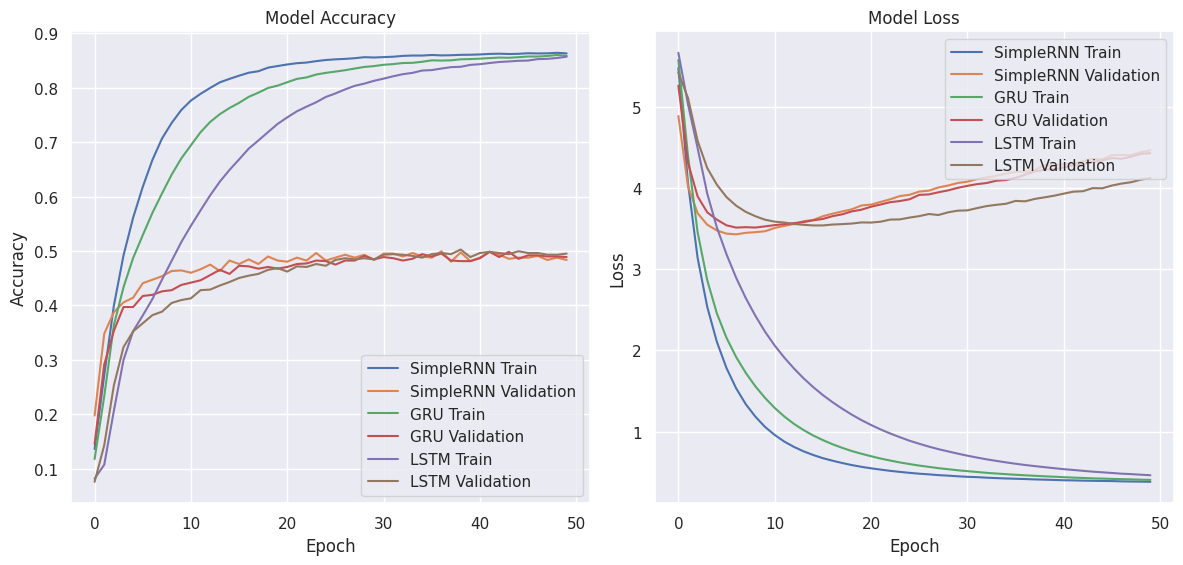

In [380]:
plot_history(basic_RNNs, "")

* SimpleRNN, LSTM, and GRU can all achieve roughly the same accuracy.
* All of the models start overfitting quickly.
* GRU is the fastest to train followed by LSTM then SimpleRNN in terms of time
* All of the models have an increasing loss over time.
* Both LSTM and GRU could work for this application so I may explore both.

## Model Improvement
* Increasing model complexity (Number of units, number of layers)
* Bidirectional
* Attention Mechanism
* n-gram Text Vectorization

In [35]:
def simple_LSTM_seq(lstm_units):
    return Sequential([
    vectorize_layer,
    Embedding(total_words, 768, mask_zero=True),
    LSTM(lstm_units),
    Dense(total_words, activation='softmax')
])

In [384]:
more_LSTMs = {}

simple_LSTM_128 = simple_LSTM_seq(128)
simple_LSTM_128.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

more_LSTMs["LSTM_128"] = fit_model(simple_LSTM_128, "", batch_size=256, epochs=50, callbacks=[])
simple_LSTM_128.save("models/LSTM_128.keras")

simple_LSTM_128_2 = Sequential([
    vectorize_layer,
    Embedding(total_words, 768, mask_zero=True),
    LSTM(128, return_sequences=True),
    LSTM(128),
    Dense(total_words, activation='softmax')
])
simple_LSTM_128_2.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

more_LSTMs["LSTM_128_2"] = fit_model(simple_LSTM_128_2, "", batch_size=256, epochs=50, callbacks=[])
simple_LSTM_128_2.save("models/LSTM_128_2.keras")

Epoch 1/50
172/172 [==============================] - 8s 38ms/step - loss: 5.4125 - accuracy: 0.1237 - val_loss: 4.9305 - val_accuracy: 0.1729
Epoch 2/50
172/172 [==============================] - 4s 22ms/step - loss: 4.1491 - accuracy: 0.2551 - val_loss: 4.2749 - val_accuracy: 0.3148
Epoch 3/50
172/172 [==============================] - 4s 21ms/step - loss: 3.4062 - accuracy: 0.3551 - val_loss: 3.9741 - val_accuracy: 0.3618
Epoch 4/50
172/172 [==============================] - 3s 20ms/step - loss: 2.8992 - accuracy: 0.4117 - val_loss: 3.8083 - val_accuracy: 0.3991
Epoch 5/50
172/172 [==============================] - 3s 19ms/step - loss: 2.5086 - accuracy: 0.4712 - val_loss: 3.6995 - val_accuracy: 0.4013
Epoch 6/50
172/172 [==============================] - 3s 19ms/step - loss: 2.1871 - accuracy: 0.5269 - val_loss: 3.6395 - val_accuracy: 0.4226
Epoch 7/50
172/172 [==============================] - 3s 19ms/step - loss: 1.9183 - accuracy: 0.5739 - val_loss: 3.5940 - val_accuracy: 0.4333

  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 1/50
172/172 [==============================] - 11s 47ms/step - loss: 5.6235 - accuracy: 0.0737 - val_loss: 5.6622 - val_accuracy: 0.0768
Epoch 2/50
172/172 [==============================] - 5s 30ms/step - loss: 5.2748 - accuracy: 0.1071 - val_loss: 5.4134 - val_accuracy: 0.1430
Epoch 3/50
172/172 [==============================] - 5s 28ms/step - loss: 4.7719 - accuracy: 0.1481 - val_loss: 4.9369 - val_accuracy: 0.1654
Epoch 4/50
172/172 [==============================] - 5s 29ms/step - loss: 4.2350 - accuracy: 0.2160 - val_loss: 4.6818 - val_accuracy: 0.2284
Epoch 5/50
172/172 [==============================] - 5s 27ms/step - loss: 3.8574 - accuracy: 0.2579 - val_loss: 4.4580 - val_accuracy: 0.2818
Epoch 6/50
172/172 [==============================] - 5s 27ms/step - loss: 3.5031 - accuracy: 0.3130 - val_loss: 4.2705 - val_accuracy: 0.3255
Epoch 7/50
172/172 [==============================] - 5s 27ms/step - loss: 3.1699 - accuracy: 0.3681 - val_loss: 4.1283 - val_accuracy: 0.360

  0%|          | 0/151 [00:00<?, ?it/s]

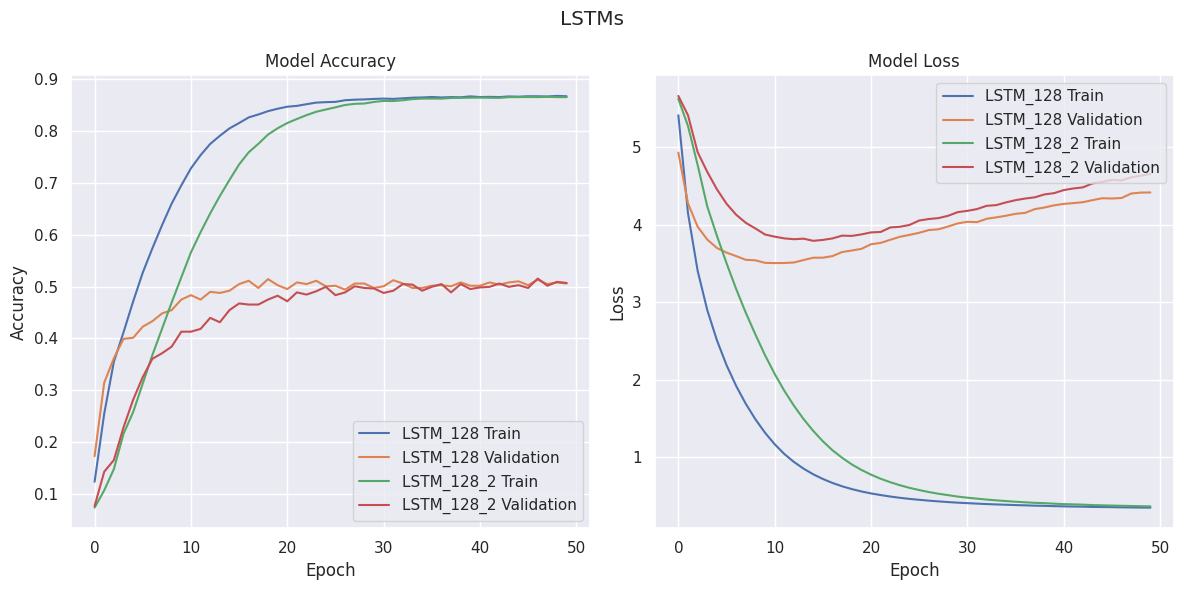

In [386]:
plot_history(more_LSTMs, "LSTMs")

No benefit to using 2 layers since the data is already not very complex.

In [45]:
more_LSTMs = {}

simple_LSTM_256 = simple_LSTM_seq(256)
simple_LSTM_256.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

more_LSTMs["LSTM_256"] = fit_model(simple_LSTM_256, "", batch_size=256, epochs=50, callbacks=[])
simple_LSTM_256.save("models/LSTM_256.keras")

simple_LSTM_512 = simple_LSTM_seq(512)
simple_LSTM_512.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

more_LSTMs["LSTM_512"] = fit_model(simple_LSTM_512, "", batch_size=256, epochs=50, callbacks=[])
simple_LSTM_512.save("models/LSTM_512.keras")

simple_LSTM_1024 = simple_LSTM_seq(1024)
simple_LSTM_1024.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

more_LSTMs["LSTM_1024"] = fit_model(simple_LSTM_1024, "", batch_size=256, epochs=50, callbacks=[])
simple_LSTM_1024.save("models/LSTM_1024.keras")

Epoch 1/50
29/29 [==============================] - 4s 77ms/step - loss: 6.3037 - accuracy: 0.1056 - val_loss: 5.5508 - val_accuracy: 0.0779
Epoch 2/50
29/29 [==============================] - 1s 50ms/step - loss: 5.3376 - accuracy: 0.0967 - val_loss: 5.3293 - val_accuracy: 0.0982
Epoch 3/50
29/29 [==============================] - 1s 37ms/step - loss: 5.0172 - accuracy: 0.1393 - val_loss: 4.9986 - val_accuracy: 0.1377
Epoch 4/50
29/29 [==============================] - 1s 30ms/step - loss: 4.6428 - accuracy: 0.1875 - val_loss: 4.6758 - val_accuracy: 0.2380
Epoch 5/50
29/29 [==============================] - 1s 28ms/step - loss: 4.2424 - accuracy: 0.2720 - val_loss: 4.3712 - val_accuracy: 0.3116
Epoch 6/50
29/29 [==============================] - 1s 34ms/step - loss: 3.8892 - accuracy: 0.3349 - val_loss: 4.1454 - val_accuracy: 0.3415
Epoch 7/50
29/29 [==============================] - 1s 26ms/step - loss: 3.6050 - accuracy: 0.3687 - val_loss: 3.9824 - val_accuracy: 0.3842
Epoch 8/50
29

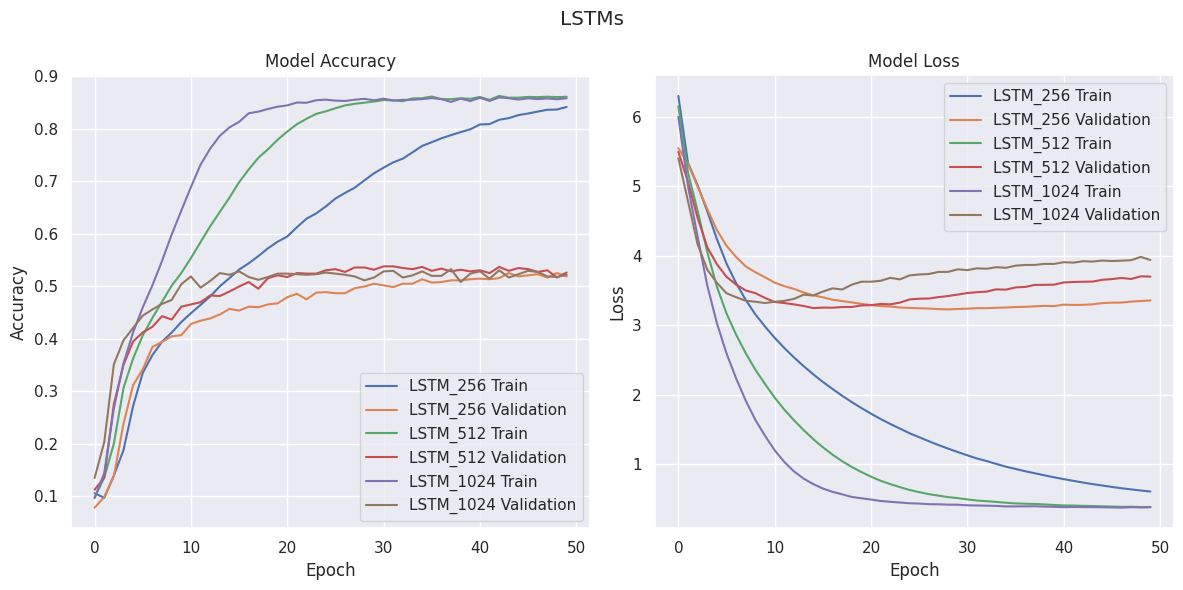

In [47]:
plot_history(more_LSTMs, "LSTMs")

In [48]:
objective_task(simple_LSTM_256)

  0%|          | 0/10 [00:00<?, ?it/s]

['embrace each day is a fresh chance for new beginnings reminding us of',
 "radiate some and let it be the foundation of your day's",
 'believe that you are a testament to the beauty of many success',
 "life's actual purpose is a tapestry woven with threads of love and joy and",
 'dance through each and every moment of a brand new day full of kindness and',
 'let your time and energy be the compass that guides you home your purpose and',
 'every person is a gift a reminder of the universe and potential to',
 "our country singapore is a testament to the beauty of nature's palette and",
 "planet earth is a testament to the beauty of life's vitality and",
 'morning and evening would make it is a gift to everyone you meet around you to']

In [49]:
objective_task(simple_LSTM_512)

  0%|          | 0/10 [00:00<?, ?it/s]

['embrace each day is a symphony of joy a melody that resonates that',
 'radiate some for it is the truest expression of your essence and',
 'believe that you are a mark of a fresh start and new',
 "life's actual purpose is the pursuit of our passions and dreams are the compass",
 'dance through each and every melody of a joyful heart heart they hold the heart',
 'let your time and energy to the world around you home you of the heart',
 "every person is a reminder of the gift of light and life's",
 "our country singapore is written with the stories of life's refreshment and renewal",
 "planet earth is a testament to the life's adaptability and strength to",
 'morning and evening would make it illuminates the world around you of the world of your']

In [50]:
objective_task(simple_LSTM_1024)

  0%|          | 0/10 [00:00<?, ?it/s]

['embrace each day is a symphony of joy in the heart of the',
 'radiate some and let it be the tapestry of your character of',
 'believe that you are the architect of your destiny and aspirations and',
 "life's actual purpose is a tapestry woven with threads of love and laughter for",
 'dance through each and every savoring the beauty it holds the promise of new beginnings',
 'let your time and energy to the seeds that your your heart and the world',
 'every person is a setup for a glorious comeback to the beauty of',
 'our country singapore is the stages for stories of endurance and adaptation forth endurance',
 'planet earth is the cradle of biodiversity and resilience and resilience and let',
 'morning and evening would make it is the gift of your soul and soul a adventures']

In [51]:
ngram_RNNs = {}
max_vocab_size = 50000

vectorize_layer = TextVectorization(
    max_tokens=max_vocab_size,
    output_mode='int',
    output_sequence_length=200,
    ngrams=1
)

vectorize_layer.adapt([" ".join(x) for x in clean_sentences_for_input(tokenized_quotes)])

simple_LSTM_256_1gram = simple_LSTM_seq(256)
simple_LSTM_256_1gram.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

ngram_RNNs["1-gram"] = fit_model(simple_LSTM_256_1gram, "", batch_size=256, epochs=50, callbacks=[])
simple_LSTM_256_1gram.save("models/LSTM_256_1gram.keras")

vectorize_layer = TextVectorization(
    max_tokens=max_vocab_size,
    output_mode='int',
    output_sequence_length=200,
    ngrams=2
)

vectorize_layer.adapt([" ".join(x) for x in clean_sentences_for_input(tokenized_quotes)])

simple_LSTM_256_2gram = simple_LSTM_seq(256)
simple_LSTM_256_2gram.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

ngram_RNNs["2-gram"] = fit_model(simple_LSTM_256_2gram, "", batch_size=256, epochs=50, callbacks=[])
simple_LSTM_256_2gram.save("models/LSTM_256_2gram.keras")

vectorize_layer = TextVectorization(
    max_tokens=max_vocab_size,
    output_mode='int',
    output_sequence_length=200,
    ngrams=3
)

vectorize_layer.adapt([" ".join(x) for x in clean_sentences_for_input(tokenized_quotes)])

simple_LSTM_256_3gram = simple_LSTM_seq(256)
simple_LSTM_256_3gram.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

ngram_RNNs["3-gram"] = fit_model(simple_LSTM_256_3gram, "", batch_size=256, epochs=50, callbacks=[])
simple_LSTM_256_3gram.save("models/LSTM_256_3gram.keras")

vectorize_layer = TextVectorization(
    max_tokens=max_vocab_size,
    output_mode='int',
    output_sequence_length=200,
    ngrams=4
)

vectorize_layer.adapt([" ".join(x) for x in clean_sentences_for_input(tokenized_quotes)])

simple_LSTM_256_4gram = simple_LSTM_seq(256)
simple_LSTM_256_4gram.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

ngram_RNNs["4-gram"] = fit_model(simple_LSTM_256_4gram, "", batch_size=256, epochs=50, callbacks=[])
simple_LSTM_256_4gram.save("models/LSTM_256_4gram.keras")

Epoch 1/50
29/29 [==============================] - 4s 76ms/step - loss: 6.3516 - accuracy: 0.1023 - val_loss: 5.5741 - val_accuracy: 0.0779
Epoch 2/50
29/29 [==============================] - 2s 57ms/step - loss: 5.3391 - accuracy: 0.1069 - val_loss: 5.3049 - val_accuracy: 0.1387
Epoch 3/50
29/29 [==============================] - 1s 38ms/step - loss: 4.9664 - accuracy: 0.1467 - val_loss: 4.9187 - val_accuracy: 0.1398
Epoch 4/50
29/29 [==============================] - 1s 33ms/step - loss: 4.5532 - accuracy: 0.2147 - val_loss: 4.5923 - val_accuracy: 0.2711
Epoch 5/50
29/29 [==============================] - 1s 32ms/step - loss: 4.1676 - accuracy: 0.2904 - val_loss: 4.2956 - val_accuracy: 0.3223
Epoch 6/50
29/29 [==============================] - 1s 38ms/step - loss: 3.8270 - accuracy: 0.3444 - val_loss: 4.0680 - val_accuracy: 0.3607
Epoch 7/50
29/29 [==============================] - 1s 33ms/step - loss: 3.5569 - accuracy: 0.3680 - val_loss: 3.9300 - val_accuracy: 0.3895
Epoch 8/50
29

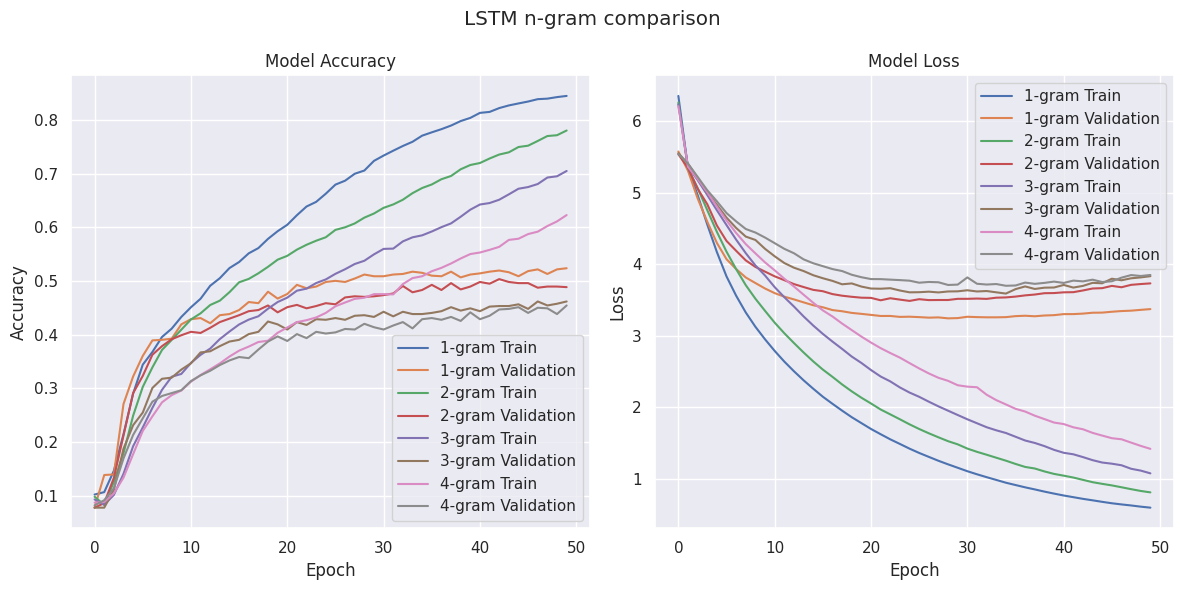

In [52]:
plot_history(ngram_RNNs, "LSTM n-gram comparison")

In [53]:
objective_task(simple_LSTM_256_1gram)

  0%|          | 0/10 [00:00<?, ?it/s]

['embrace each day is a gift a reminder of the preciousness of life',
 'radiate some and let it be the foundation of your soul and',
 'believe that yourself and you will be a source of light for',
 "life's actual purpose is the pursuit of our heart's deepest desires's deepest",
 "dance through each and every whispers of your heart's desires to the beauty of",
 'let your time and energy be the bridge that connects hearts and happiness far and',
 'every person is a story of hope for a fresh start and new',
 "our country singapore is a sanctuary to pulau ubin's simplicity singapore's nature",
 "planet earth is a sanctuary to universal studios singapore's attractions are world",
 'morning and evening would make it with joy that illuminates the world around you home you']

In [54]:
objective_task(simple_LSTM_256_2gram)

  0%|          | 0/10 [00:00<?, ?it/s]

['embrace each day for it is the heartbeat of a joyful heart for',
 'radiate some and let it be the legacy of love you joy',
 'believe that yourself you is a testament to the strength and resilience',
 "life's actual purpose is by the light of our inner wisdom and love and",
 'dance through each and every the it beauty us beauty beauty beauty beauty true beauty',
 'let your time and energy be the compass that guides your way of your destiny',
 'every person is will a the of the soul and brings of new',
 "our country singapore is the heartbeat of the soul for our planet's future",
 "planet earth is the melody of a life well lived life's vitality",
 'morning and evening would make it a of the beauty of the universe a possibilities of']

In [55]:
objective_task(simple_LSTM_256_3gram)

  0%|          | 0/10 [00:00<?, ?it/s]

['embrace each day it a a gift future future new future future future',
 'radiate some and let it be the foundation of your legacy and',
 'believe that chapter chapter chapter chapter chapter chapter chapter chapter chapter chapter',
 "life's actual purpose is by to to the and our potential and life and",
 'dance through each and every it the a of in the of potential potential planet',
 'let your time and energy force the your your purpose purpose and you and of',
 'every person is a reminder of the cycles of life for life planet',
 'our country singapore is the of and to purpose and a of the of',
 'planet earth is the of to and the of path and future future',
 'morning and evening would make it a to future future a future future future new future']

In [56]:
objective_task(simple_LSTM_256_4gram)

  0%|          | 0/10 [00:00<?, ?it/s]

['embrace each day is a canvas for your the of joy the life',
 'radiate some and let it be the foundation of your strength and',
 'believe that yourself and your lead and of the of the of',
 "life's actual purpose is the we we the of we the our and's",
 "dance through each and every a your life life's's inner's inner inner",
 'let your time and energy the the halls your of the life of and and',
 "every person is a setup of the our planet's and and and",
 'our country singapore is soothes embodiment embodiment embodiment embodiment embodiment embodiment embodiment embodiment embodiment',
 "planet earth is the to and with of a's's our's",
 "morning and evening would make it the future of our planet's wisdom and and and"]

In [57]:
vectorize_layer("let your time and energy through the world around you")

<tf.Tensor: shape=(200,), dtype=int64, numpy=
array([  11,    4, 1207,    5,  588,   45,    2,  102,  509,   18,   21,
          1,    1,    1,    1,   60,  131, 1738,  508,    1,    1,    1,
          1,    1, 6102, 1855, 1737,    1,    1,    1,    1,    1,    1,
       1854,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
     

* Since the dataset is small, there are many n-grams that will not appear in the dataset. Thus they will be set to `1` which skews the results. 
* The result of the n-gram encoding also performs much worse than 1-gram. Thus I will not use n-gram text vectorization.

### Bi-Directional

In [38]:
other_RNNs = {}

In [40]:
simple_Bi_LSTM_256 = Sequential([
    vectorize_layer,
    Embedding(total_words, 768, mask_zero=True),
    Bidirectional(LSTM(256)),
    Dense(total_words, activation='softmax')
])
simple_Bi_LSTM_256.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

other_RNNs["Bi_LSTM_256"] = fit_model(simple_Bi_LSTM_256, "", batch_size=64, epochs=50, callbacks=[])
simple_Bi_LSTM_256.save("models/Bi_LSTM_256.keras")

Epoch 1/50
114/114 [==============================] - 8s 44ms/step - loss: 5.5409 - accuracy: 0.1249 - val_loss: 4.6244 - val_accuracy: 0.2263
Epoch 2/50
114/114 [==============================] - 2s 21ms/step - loss: 3.9677 - accuracy: 0.3107 - val_loss: 3.7903 - val_accuracy: 0.3810
Epoch 3/50
114/114 [==============================] - 2s 20ms/step - loss: 3.0187 - accuracy: 0.4121 - val_loss: 3.4709 - val_accuracy: 0.4365
Epoch 4/50
114/114 [==============================] - 2s 18ms/step - loss: 2.3666 - accuracy: 0.4871 - val_loss: 3.3166 - val_accuracy: 0.4578
Epoch 5/50
114/114 [==============================] - 2s 18ms/step - loss: 1.8925 - accuracy: 0.5636 - val_loss: 3.2534 - val_accuracy: 0.4856
Epoch 6/50
114/114 [==============================] - 2s 18ms/step - loss: 1.5168 - accuracy: 0.6229 - val_loss: 3.2678 - val_accuracy: 0.4771
Epoch 7/50
114/114 [==============================] - 2s 18ms/step - loss: 1.2371 - accuracy: 0.6805 - val_loss: 3.2778 - val_accuracy: 0.5037

In [44]:
objective_task(simple_Bi_LSTM_256)

  0%|          | 0/10 [00:00<?, ?it/s]

['embrace each day is a fresh canvas paint it with vibrant strokes of',
 'radiate some and let it be the foundation of your strength and',
 "believe that you'll are worthy of compassion letting kindness be your",
 "life's actual purpose is a testament to the beauty of our uniqueness and soul",
 'dance through each and every moment of gratitude is the step a step towards the',
 'let your time and energy be the bridge that fosters understanding and joy understanding and',
 "every person is a reminder of the preciousness of life's journey a",
 'our country singapore is the stages for stories of endurance and adaptation adaptation reality',
 'planet earth is a testament to the strength and resilience of our planet',
 'morning and evening would make it with a joyful heart full of gratitude and the world']

In [60]:
simple_RNN = load_model("models/SimpleRNN.keras")
simple_GRU = load_model("models/GRU.keras")
simple_LSTM = load_model("models/LSTM.keras")
simple_LSTM_128 = load_model("models/LSTM_128.keras")
simple_LSTM_128_2 = load_model("models/LSTM_128_2.keras")
simple_LSTM_256 = load_model("models/LSTM_256.keras")
simple_LSTM_512 = load_model("models/LSTM_512.keras")
simple_LSTM_1024 = load_model("models/LSTM_1024.keras")
simple_LSTM_256_1gram = load_model("models/LSTM_256_1gram.keras")
simple_LSTM_256_2gram = load_model("models/LSTM_256_2gram.keras")
simple_LSTM_256_3gram = load_model("models/LSTM_256_3gram.keras")
simple_LSTM_256_4gram = load_model("models/LSTM_256_4gram.keras")
simple_Bi_LSTM_256 = load_model("models/Bi_LSTM_256.keras")

In [61]:
all_RNN_scores = {}
all_RNN_scores["SimpleRNN"] = calculate_scoring_metrics(simple_RNN)
all_RNN_scores["GRU"] = calculate_scoring_metrics(simple_GRU)
all_RNN_scores["LSTM"] = calculate_scoring_metrics(simple_LSTM)
all_RNN_scores["LSTM_128"] = calculate_scoring_metrics(simple_LSTM_128)
all_RNN_scores["LSTM_128_2"] = calculate_scoring_metrics(simple_LSTM_128_2)
all_RNN_scores["LSTM_256"] = calculate_scoring_metrics(simple_LSTM_256)
all_RNN_scores["LSTM_512"] = calculate_scoring_metrics(simple_LSTM_512)
all_RNN_scores["LSTM_1024"] = calculate_scoring_metrics(simple_LSTM_1024)
all_RNN_scores["LSTM_256_1gram"] = calculate_scoring_metrics(simple_LSTM_256_1gram)
all_RNN_scores["LSTM_256_2gram"] = calculate_scoring_metrics(simple_LSTM_256_2gram)
all_RNN_scores["LSTM_256_3gram"] = calculate_scoring_metrics(simple_LSTM_256_3gram)
all_RNN_scores["LSTM_256_4gram"] = calculate_scoring_metrics(simple_LSTM_256_4gram)
all_RNN_scores["Bi_LSTM_256"] = calculate_scoring_metrics(simple_Bi_LSTM_256)

  0%|          | 0/151 [00:00<?, ?it/s]

  0%|          | 0/151 [00:00<?, ?it/s]

  0%|          | 0/151 [00:00<?, ?it/s]

  0%|          | 0/151 [00:00<?, ?it/s]

  0%|          | 0/151 [00:00<?, ?it/s]

  0%|          | 0/151 [00:00<?, ?it/s]

  0%|          | 0/151 [00:00<?, ?it/s]

  0%|          | 0/151 [00:00<?, ?it/s]

  0%|          | 0/151 [00:00<?, ?it/s]

  0%|          | 0/151 [00:00<?, ?it/s]

  0%|          | 0/151 [00:00<?, ?it/s]

  0%|          | 0/151 [00:00<?, ?it/s]

  0%|          | 0/151 [00:00<?, ?it/s]

In [65]:
def display_scores(x):
    return {k: v[0] for k, v in x.items()}

In [65]:
display_scores(all_RNN_scores)

{'SimpleRNN': {'mean_mistakes': 0.40397350993377484,
  'bleu': 0.07405432930676906},
 'GRU': {'mean_mistakes': 0.6887417218543046, 'bleu': 0.07288359458915684},
 'LSTM': {'mean_mistakes': 0.7152317880794702, 'bleu': 0.07177141500098787},
 'LSTM_128': {'mean_mistakes': 1.1456953642384107,
  'bleu': 0.06993912071796662},
 'LSTM_128_2': {'mean_mistakes': 0.6688741721854304,
  'bleu': 0.07315796462552174},
 'LSTM_256': {'mean_mistakes': 0.046357615894039736,
  'bleu': 0.9214361881709755},
 'LSTM_512': {'mean_mistakes': 0.08609271523178808, 'bleu': 0.918030355700707},
 'LSTM_1024': {'mean_mistakes': 0.13245033112582782,
  'bleu': 0.9177425197493823},
 'LSTM_256_1gram': {'mean_mistakes': 0.052980132450331126,
  'bleu': 0.9159296684505913},
 'LSTM_256_2gram': {'mean_mistakes': 0.2913907284768212,
  'bleu': 0.8483126801477692},
 'LSTM_256_3gram': {'mean_mistakes': 0.3973509933774834,
  'bleu': 0.7701729208914927},
 'LSTM_256_4gram': {'mean_mistakes': 0.7086092715231788,
  'bleu': 0.71741963782

## Other Improvements
* Dropout after Embedding
* Self-Attention

In [41]:
LSTM_Dropout_256 = Sequential([
    vectorize_layer,
    Embedding(total_words, 768, mask_zero=True),
    Dropout(0.3),
    LSTM(256),
    Dense(total_words, activation='softmax')
])
simple_LSTM_Dropout_256.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

other_RNNs["LSTM_Dropout_256"] = fit_model(LSTM_Dropout_256, "", batch_size=64, epochs=50, callbacks=[])
LSTM_Dropout_256.save("models/LSTM_Dropout_256.keras")

Epoch 1/50
114/114 [==============================] - 6s 41ms/step - loss: 5.7030 - accuracy: 0.1054 - val_loss: 5.0878 - val_accuracy: 0.1377
Epoch 2/50
114/114 [==============================] - 2s 17ms/step - loss: 4.5768 - accuracy: 0.2224 - val_loss: 4.3160 - val_accuracy: 0.3255
Epoch 3/50
114/114 [==============================] - 2s 15ms/step - loss: 3.7784 - accuracy: 0.3431 - val_loss: 3.8986 - val_accuracy: 0.3895
Epoch 4/50
114/114 [==============================] - 2s 14ms/step - loss: 3.2373 - accuracy: 0.4026 - val_loss: 3.6644 - val_accuracy: 0.4216
Epoch 5/50
114/114 [==============================] - 2s 14ms/step - loss: 2.8326 - accuracy: 0.4477 - val_loss: 3.5147 - val_accuracy: 0.4322
Epoch 6/50
114/114 [==============================] - 2s 14ms/step - loss: 2.5059 - accuracy: 0.4861 - val_loss: 3.4134 - val_accuracy: 0.4408
Epoch 7/50
114/114 [==============================] - 1s 13ms/step - loss: 2.2364 - accuracy: 0.5187 - val_loss: 3.3300 - val_accuracy: 0.4482

In [45]:
objective_task(LSTM_Dropout_256)

  0%|          | 0/10 [00:00<?, ?it/s]

['embrace each day is a fresh canvas paint it with vibrant strokes of',
 'radiate some for it is the foundation of genuine connection for weary',
 'believe that you are the architect of your destiny paint it with',
 "life's actual purpose is a testament to the beauty of our uniqueness and the",
 'dance through each and every moment of gratitude for it is a gift of new',
 'let your time and energy to the seeds and your heart and soul you to',
 'every person is a beacon of light and strength for others will follow',
 'our country singapore is the stages for stories of endurance and adaptation and breathtaking',
 'planet earth is the cradle of biodiversity and resilience of progress and determination',
 'morning and evening would make it with warmth and appreciation into the assurance that you are']

In [54]:
input_layer = Input(shape=(1,), dtype=tf.string)
_vectorize_layer = vectorize_layer(input_layer)
embedding_layer = Embedding(total_words, 768, mask_zero=True)(_vectorize_layer)
dropout_layer = Dropout(0.3)(embedding_layer)
lstm_layer = LSTM(256)(dropout_layer)
attention = Attention(use_scale=True)([lstm_layer, lstm_layer])
output_layer = Dense(total_words, activation='softmax')(lstm_layer)
LSTM_Dropout_Attention_256 = Model(inputs=input_layer, outputs=output_layer)

LSTM_Dropout_SelfAttention_256.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
other_RNNs["LSTM_Dropout_SelfAttention_256"] = fit_model(LSTM_Dropout_SelfAttention_256, "", batch_size=64, epochs=50, callbacks=[])
LSTM_Dropout_SelfAttention_256.save("models/LSTM_Dropout_SelfAttention_256.keras")

Epoch 1/50
114/114 [==============================] - 6s 43ms/step - loss: 5.7003 - accuracy: 0.1016 - val_loss: 5.0804 - val_accuracy: 0.1355
Epoch 2/50
114/114 [==============================] - 2s 16ms/step - loss: 4.5514 - accuracy: 0.2238 - val_loss: 4.2889 - val_accuracy: 0.3255
Epoch 3/50
114/114 [==============================] - 2s 14ms/step - loss: 3.7482 - accuracy: 0.3412 - val_loss: 3.8903 - val_accuracy: 0.3821
Epoch 4/50
114/114 [==============================] - 1s 12ms/step - loss: 3.2225 - accuracy: 0.4010 - val_loss: 3.6798 - val_accuracy: 0.4120
Epoch 5/50
114/114 [==============================] - 1s 13ms/step - loss: 2.8365 - accuracy: 0.4434 - val_loss: 3.5267 - val_accuracy: 0.4322
Epoch 6/50
114/114 [==============================] - 1s 13ms/step - loss: 2.5157 - accuracy: 0.4848 - val_loss: 3.4171 - val_accuracy: 0.4440
Epoch 7/50
114/114 [==============================] - 1s 13ms/step - loss: 2.2436 - accuracy: 0.5154 - val_loss: 3.3276 - val_accuracy: 0.4568

In [55]:
objective_task(LSTM_Dropout_Attention_256)

  0%|          | 0/10 [00:00<?, ?it/s]

["embrace each day for it is the only constant in life's beautiful",
 'radiate some for it is the truest expression of your essence of',
 'believe that city innovation sparks and realized flight flight into treasures and',
 "life's actual purpose is reflected in the eyes of those we love we give",
 'dance through each and every a fresh chance for they are the blueprints of your',
 'let your time and energy be the compass that guides you to your purpose and',
 'every person is a reminder of the miracle of life on the universe',
 'our country singapore is a tapestry woven with threads of life and stability and',
 'planet earth is the nurseries of biodiversity and life for many coastal species',
 "morning and evening would make it with warmth and appreciation of your life's song of"]

In [57]:
input_layer = Input(shape=(1,), dtype=tf.string)
_vectorize_layer = vectorize_layer(input_layer)
embedding_layer = Embedding(total_words, 768, mask_zero=True)(_vectorize_layer)
dropout_layer = Dropout(0.3)(embedding_layer)
lstm_layer_1, hidden_state, _ = LSTM(256, return_sequences=True, return_state=True)(dropout_layer)
attention = Attention(use_scale=True)([lstm_layer_1, hidden_state])
add = tf.keras.layers.Add()([attention, lstm_layer_1])
norm = tf.keras.layers.LayerNormalization()(add)
lstm_layer_3 = LSTM(256)(norm)
output_layer = Dense(total_words, activation='softmax')(lstm_layer_3)
LSTM_Dropout_SelfAttention_2 = Model(inputs=input_layer, outputs=output_layer)

early_stopping = EarlyStopping(
    monitor="loss",
    start_from_epoch=0,
    patience=5,
    min_delta=0.01,
    mode="min",
    restore_best_weights=True
)

LSTM_Dropout_SelfAttention_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
other_RNNs["LSTM_Dropout_SelfAttention_256_2"] = fit_model(LSTM_Dropout_SelfAttention_2, "", batch_size=64, epochs=50, callbacks=[])
LSTM_Dropout_SelfAttention_2.save("models/LSTM_Dropout_SelfAttention_2.keras")

Epoch 1/50
114/114 [==============================] - 9s 56ms/step - loss: 5.5676 - accuracy: 0.0898 - val_loss: 5.0292 - val_accuracy: 0.1558
Epoch 2/50
114/114 [==============================] - 3s 24ms/step - loss: 4.3973 - accuracy: 0.2657 - val_loss: 4.0304 - val_accuracy: 0.3703
Epoch 3/50
114/114 [==============================] - 2s 21ms/step - loss: 3.4642 - accuracy: 0.3863 - val_loss: 3.6123 - val_accuracy: 0.4280
Epoch 4/50
114/114 [==============================] - 2s 20ms/step - loss: 2.8409 - accuracy: 0.4576 - val_loss: 3.3993 - val_accuracy: 0.4610
Epoch 5/50
114/114 [==============================] - 2s 19ms/step - loss: 2.3982 - accuracy: 0.5096 - val_loss: 3.2776 - val_accuracy: 0.4632
Epoch 6/50
114/114 [==============================] - 2s 21ms/step - loss: 2.0525 - accuracy: 0.5584 - val_loss: 3.1752 - val_accuracy: 0.4760
Epoch 7/50
114/114 [==============================] - 2s 21ms/step - loss: 1.7536 - accuracy: 0.6034 - val_loss: 3.1206 - val_accuracy: 0.5027

In [58]:
objective_task(LSTM_Dropout_SelfAttention_2)

  0%|          | 0/10 [00:00<?, ?it/s]

['embrace each day is a canvas for it with kindness you to everyone',
 "radiate some and let it be the blessings in your life's",
 "believe that anything you to stones and heart singapore's skyline reaches",
 "life's actual purpose is a canvas paint it with vibrant experiences of dreams are",
 'dance through each and every of gratitude is a reminder of the world of moments',
 'let your time and energy the transform of your dreams and find their wings within',
 'every person is a ripple of kindness holds the potential to promise and',
 'our country singapore is a canvas paint it with vibrant experiences of dreams are',
 'planet earth is the universe for they hold the you of be a',
 'morning and evening would make it day with colors and gratitude you cherished are the symbol']

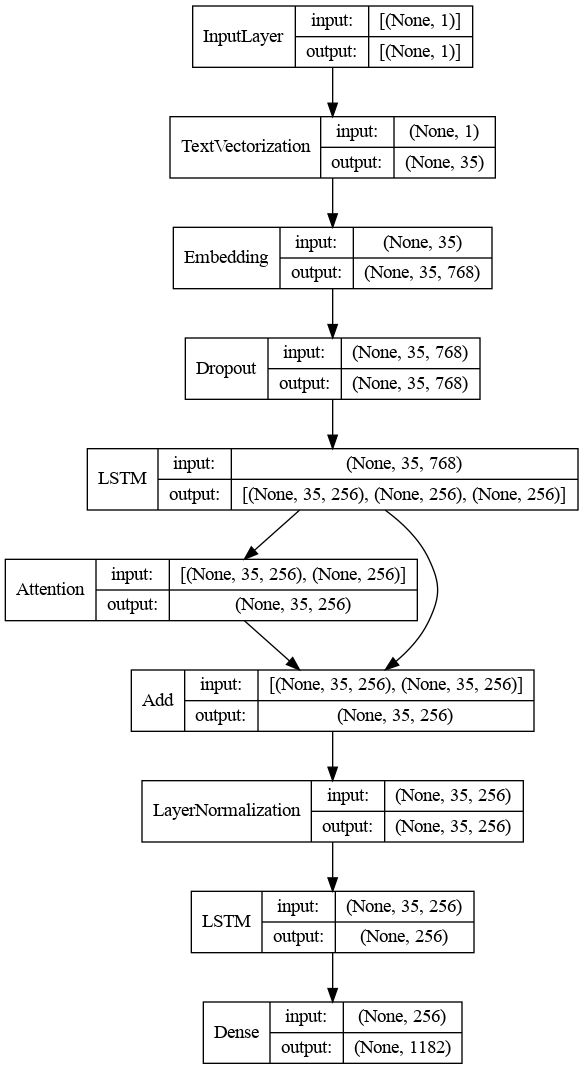

In [59]:
plot_model(LSTM_Dropout_SelfAttention_2, show_shapes=True, show_layer_names=False)

In [72]:
input_layer = Input(shape=(1,), dtype=tf.string)
_vectorize_layer = vectorize_layer(input_layer)
embedding_layer = Embedding(total_words, 768, mask_zero=True)(_vectorize_layer)
dropout_layer = Dropout(0.3)(embedding_layer)

def encoder_stack_attention(input, lstm_units):
    lstm_layer, lstm_hidden_state, _ = LSTM(lstm_units, return_sequences=True, return_state=True, recurrent_regularizer='l2')(input)
    attention = Attention(use_scale=True)([lstm_layer, lstm_hidden_state])
    add = tf.keras.layers.Add()([attention, lstm_layer])
    norm = tf.keras.layers.LayerNormalization()(add)
    return norm

stack_1 = encoder_stack_attention(dropout_layer, 512)
stack_2 = encoder_stack_attention(stack_1, 512)
add_3 = tf.keras.layers.Add()([stack_1, stack_2])

lstm_layer_3 = LSTM(256)(add_3)
output_layer = Dense(total_words, activation='softmax')(lstm_layer_3)
LSTM_Dropout_SelfAttention_3 = Model(inputs=input_layer, outputs=output_layer)

LSTM_Dropout_SelfAttention_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
other_RNNs["LSTM_Dropout_SelfAttention_3"] = fit_model(LSTM_Dropout_SelfAttention_3, "", batch_size=64, epochs=50, callbacks=[])
LSTM_Dropout_SelfAttention_3.save("models/LSTM_Dropout_SelfAttention_3.keras")

Epoch 1/50
114/114 [==============================] - 15s 68ms/step - loss: 6.8190 - accuracy: 0.1029 - val_loss: 4.9608 - val_accuracy: 0.1878
Epoch 2/50
114/114 [==============================] - 4s 32ms/step - loss: 4.4452 - accuracy: 0.2665 - val_loss: 4.0986 - val_accuracy: 0.3554
Epoch 3/50
114/114 [==============================] - 3s 28ms/step - loss: 3.6042 - accuracy: 0.3709 - val_loss: 3.7376 - val_accuracy: 0.4045
Epoch 4/50
114/114 [==============================] - 3s 27ms/step - loss: 3.0409 - accuracy: 0.4353 - val_loss: 3.5324 - val_accuracy: 0.4482
Epoch 5/50
114/114 [==============================] - 3s 27ms/step - loss: 2.6283 - accuracy: 0.4841 - val_loss: 3.4224 - val_accuracy: 0.4440
Epoch 6/50
114/114 [==============================] - 3s 28ms/step - loss: 2.3084 - accuracy: 0.5261 - val_loss: 3.3729 - val_accuracy: 0.4482
Epoch 7/50
114/114 [==============================] - 3s 28ms/step - loss: 2.0362 - accuracy: 0.5636 - val_loss: 3.2783 - val_accuracy: 0.484

In [73]:
objective_task(LSTM_Dropout_SelfAttention_3)

  0%|          | 0/10 [00:00<?, ?it/s]

['embrace each day is a fresh canvas paint it with vibrant strokes of',
 'radiate some and let it be the melody of change for it',
 'believe that you have to the treasures within you have to the',
 "life's actual purpose is and be a testament to the nation's aspirations and",
 'dance through each and every counts for it is the journey of a tale worth',
 "let your time and energy be the star of our's deepest life is the",
 'every person is a gift a reminder of the marvel of existence it',
 "our country singapore is a testament to the nation's resilience and unwavering determination",
 "planet earth is a testament to the nation's resilience and let be",
 "morning and evening would make it is a testament to the nation's resilience and unwavering"]

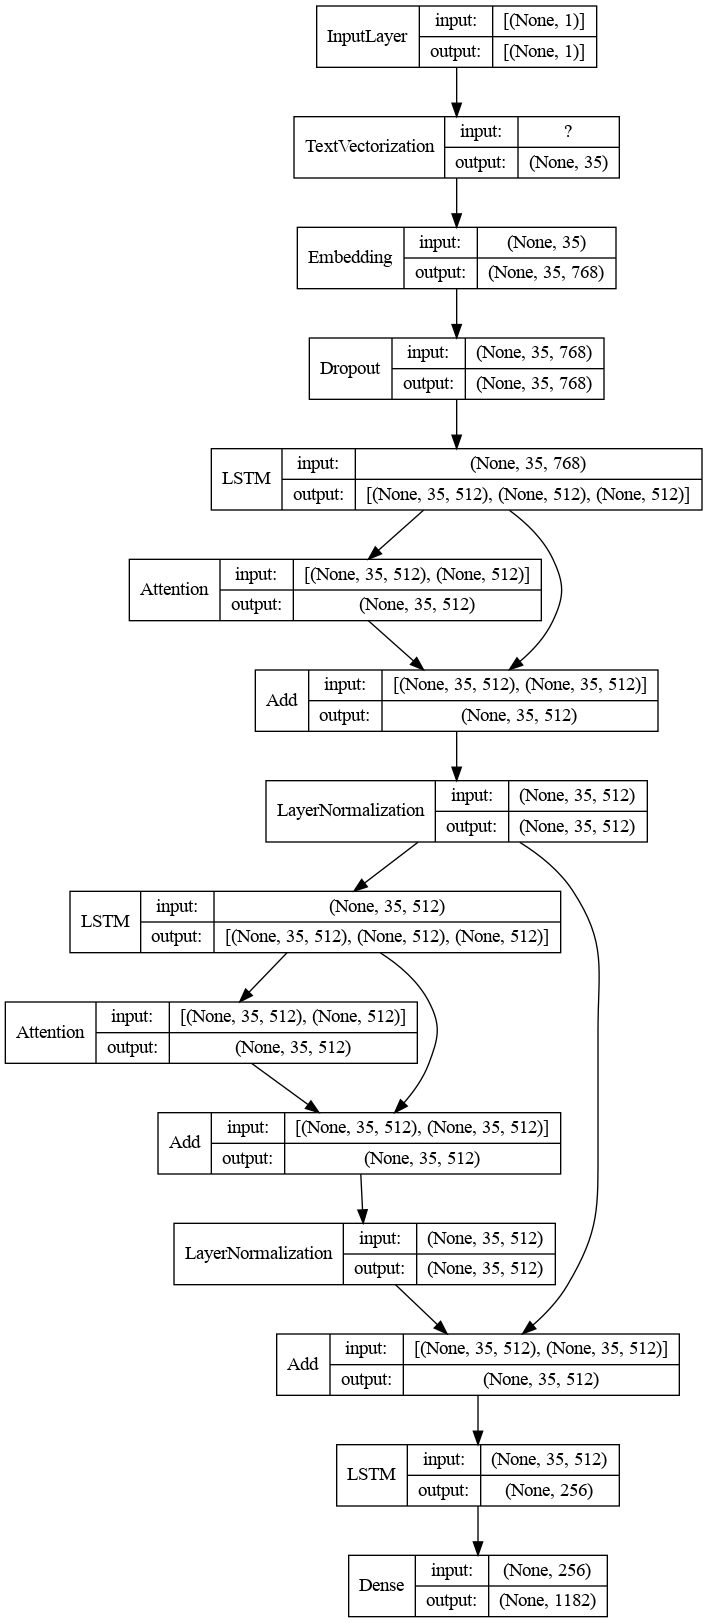

In [106]:
plot_model(LSTM_Dropout_SelfAttention_3, show_shapes=True, show_layer_names=False)

In [50]:
input_layer = Input(shape=(1,), dtype=tf.string)
_vectorize_layer = vectorize_layer(input_layer)
embedding_layer = Embedding(total_words, 768, mask_zero=True)(_vectorize_layer)
dropout_layer = Dropout(0.3)(embedding_layer)

def encoder_stack_attention(input, lstm_units):
    lstm_layer, lstm_hidden_state, _ = LSTM(lstm_units, return_sequences=True, return_state=True, recurrent_regularizer='l2', dropout=0.3)(input)
    attention = Attention(use_scale=True)([lstm_layer, lstm_hidden_state])
    add = tf.keras.layers.Add()([attention, lstm_layer])
    norm = tf.keras.layers.LayerNormalization()(add)
    return norm

stack_1 = encoder_stack_attention(dropout_layer, 512)
stack_2 = encoder_stack_attention(dropout_layer, 512)
stack_3 = encoder_stack_attention(dropout_layer, 512)
add_3 = tf.keras.layers.Concatenate()([stack_1, stack_2, stack_3])

lstm_layer_3 = LSTM(512)(add_3)
output_layer = Dense(total_words, activation='softmax')(lstm_layer_3)
LSTM_Dropout_SelfAttention_4 = Model(inputs=input_layer, outputs=output_layer)

early_stopping = EarlyStopping(
    monitor="loss",
    start_from_epoch=0,
    patience=5,
    min_delta=0.01,
    mode="min",
    restore_best_weights=True
)

LSTM_Dropout_SelfAttention_4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
other_RNNs["LSTM_Dropout_SelfAttention_4"] = fit_model(LSTM_Dropout_SelfAttention_4, "", batch_size=256, epochs=50, callbacks=[early_stopping])
LSTM_Dropout_SelfAttention_4.save("models/LSTM_Dropout_SelfAttention_4.keras")

Epoch 1/50
172/172 [==============================] - 19s 70ms/step - loss: 4.9390 - accuracy: 0.3460 - val_loss: 3.4969 - val_accuracy: 0.4034
Epoch 2/50
172/172 [==============================] - 8s 48ms/step - loss: 1.4933 - accuracy: 0.6801 - val_loss: 3.2176 - val_accuracy: 0.4899
Epoch 3/50
172/172 [==============================] - 8s 46ms/step - loss: 0.8705 - accuracy: 0.7901 - val_loss: 3.2405 - val_accuracy: 0.4995
Epoch 4/50
172/172 [==============================] - 8s 47ms/step - loss: 0.6694 - accuracy: 0.8226 - val_loss: 3.3237 - val_accuracy: 0.5165
Epoch 5/50
172/172 [==============================] - 8s 46ms/step - loss: 0.5840 - accuracy: 0.8378 - val_loss: 3.3751 - val_accuracy: 0.4995
Epoch 6/50
172/172 [==============================] - 8s 46ms/step - loss: 0.5436 - accuracy: 0.8420 - val_loss: 3.4253 - val_accuracy: 0.5123
Epoch 7/50
172/172 [==============================] - 8s 45ms/step - loss: 0.5174 - accuracy: 0.8467 - val_loss: 3.4786 - val_accuracy: 0.508

In [41]:
objective_task(LSTM_Dropout_SelfAttention_4)

  0%|          | 0/10 [00:00<?, ?it/s]

['embrace each day is a canvas for new beginnings reminding us of the',
 "radiate some for it is the heartbeat of life's journey is",
 'believe that you forward are more nurtured with and let your confidence',
 "life's actual purpose is and are a reminder of the marvel of existence and",
 'dance through each and every planted is a reminder of the hope and potential within',
 'let your time and energy be the that powers your journey a canvas paint it',
 'every person is a beacon of light a guiding star that illuminates the',
 'our country singapore is a beacon of hope and the light in the world',
 "planet earth is a testament to the nation's resilience and unwavering determination",
 "morning and evening would make it's you to a world of unity and abundance will"]

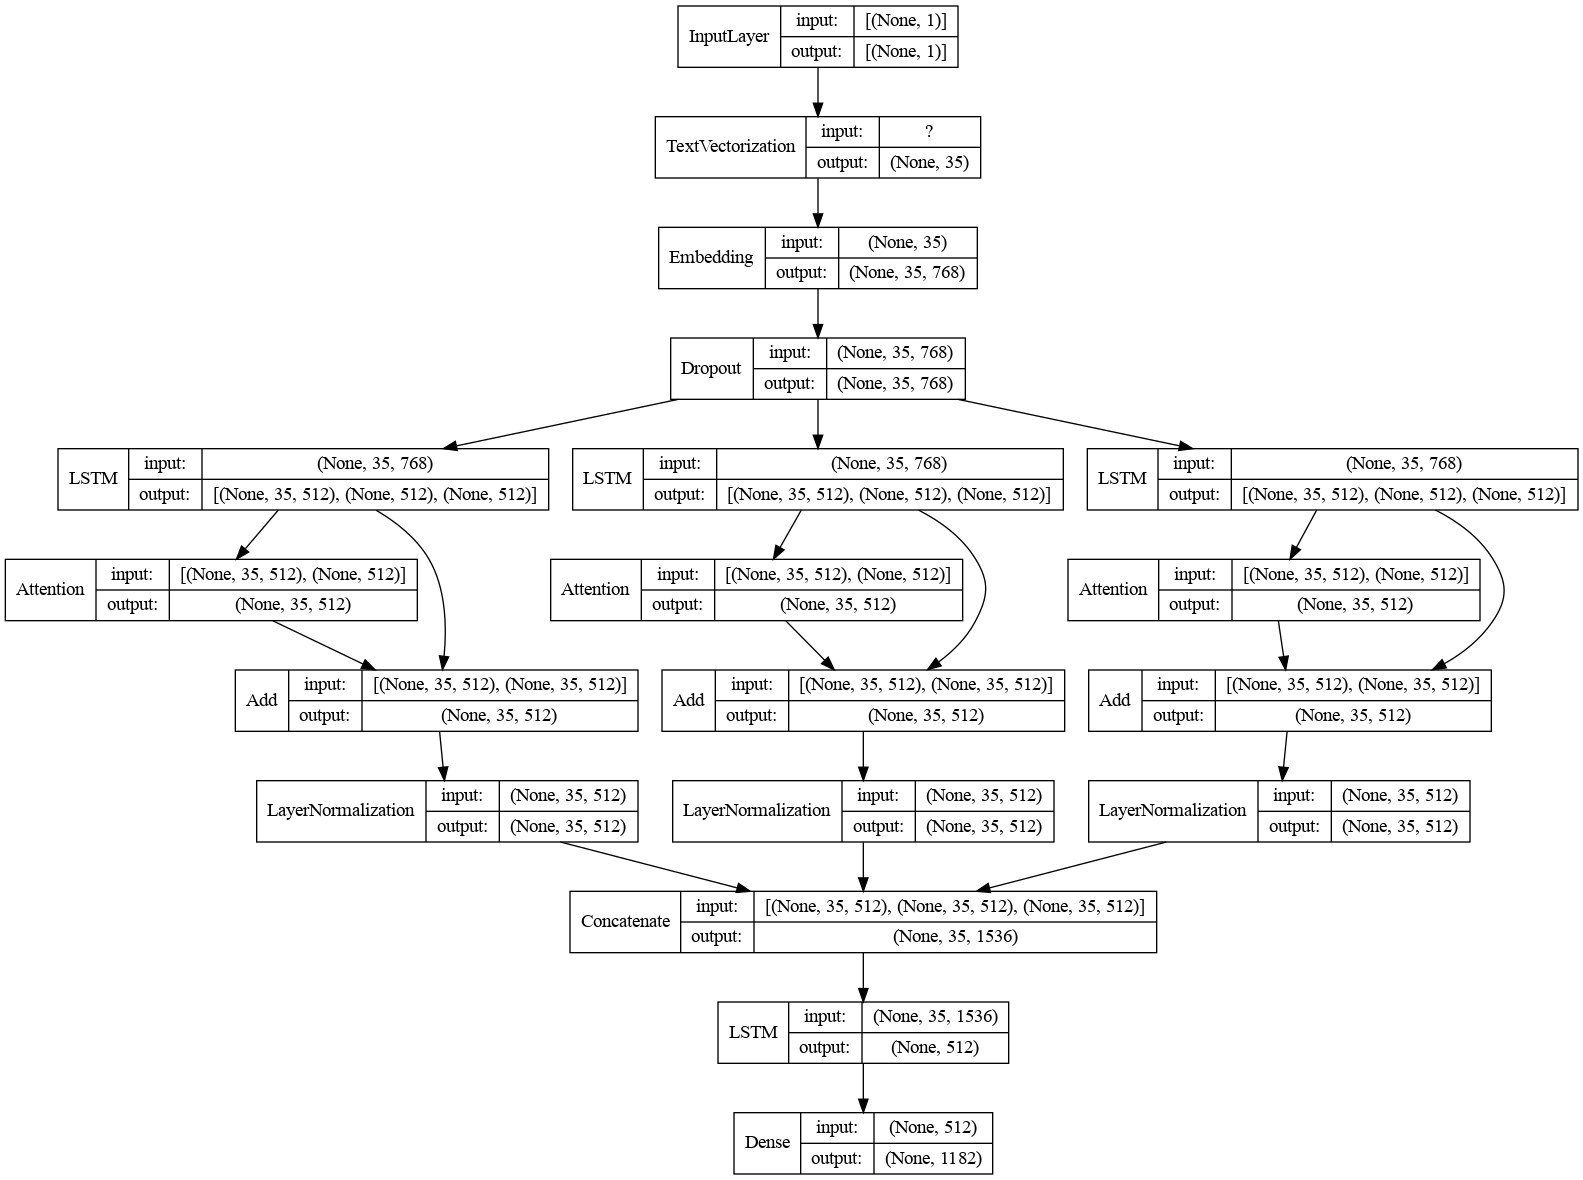

In [117]:
plot_model(LSTM_Dropout_SelfAttention_4, show_shapes=True, show_layer_names=False)

In [45]:
input_layer = Input(shape=(1,), dtype=tf.string)
_vectorize_layer = vectorize_layer(input_layer)
embedding_layer = Embedding(total_words, 768, mask_zero=True)(_vectorize_layer)
dropout_layer = Dropout(0.3)(embedding_layer)

def encoder_stack_attention_bidirectional(input, lstm_units):
    lstm_layer, lstm_hidden_state, _, lstm_rev_hidden_state, _ = Bidirectional(LSTM(lstm_units, return_state=True, recurrent_regularizer='l2', dropout=0.3))(input)
    concat = tf.keras.layers.Concatenate()([lstm_hidden_state, lstm_rev_hidden_state])
    attention = Attention(use_scale=True)([lstm_layer, concat])
    add = tf.keras.layers.Add()([attention, lstm_layer])
    norm = tf.keras.layers.LayerNormalization()(add)
    ffn = Dense(1000, activation="relu")(norm)
    return ffn

stack_1 = encoder_stack_attention_bidirectional(dropout_layer, 512)
stack_2 = encoder_stack_attention_bidirectional(dropout_layer, 512)
stack_3 = encoder_stack_attention_bidirectional(dropout_layer, 512)
add_3 = tf.keras.layers.Concatenate()([stack_1, stack_2, stack_3])

output_layer = Dense(total_words, activation='softmax')(add_3)
LSTM_Dropout_SelfAttention_5 = Model(inputs=input_layer, outputs=output_layer)

early_stopping = EarlyStopping(
    monitor="loss",
    start_from_epoch=0,
    patience=5,
    min_delta=0.01,
    mode="min",
    restore_best_weights=True
)

LSTM_Dropout_SelfAttention_5.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
other_RNNs["LSTM_Dropout_SelfAttention_5"] = fit_model(LSTM_Dropout_SelfAttention_5, "", batch_size=64, epochs=50, callbacks=[early_stopping])
LSTM_Dropout_SelfAttention_5.save("models/LSTM_Dropout_SelfAttention_5.keras")

Epoch 1/50
114/114 [==============================] - 20s 86ms/step - loss: 8.6894 - accuracy: 0.2548 - val_loss: 3.9631 - val_accuracy: 0.3799
Epoch 2/50
114/114 [==============================] - 6s 49ms/step - loss: 3.1836 - accuracy: 0.4070 - val_loss: 3.6930 - val_accuracy: 0.4088
Epoch 3/50
114/114 [==============================] - 5s 48ms/step - loss: 2.4366 - accuracy: 0.4872 - val_loss: 3.6052 - val_accuracy: 0.4194
Epoch 4/50
114/114 [==============================] - 5s 47ms/step - loss: 1.9436 - accuracy: 0.5446 - val_loss: 3.6293 - val_accuracy: 0.4386
Epoch 5/50
114/114 [==============================] - 5s 46ms/step - loss: 1.6069 - accuracy: 0.6081 - val_loss: 3.9095 - val_accuracy: 0.4365
Epoch 6/50
114/114 [==============================] - 5s 48ms/step - loss: 1.4248 - accuracy: 0.6499 - val_loss: 4.2181 - val_accuracy: 0.4621
Epoch 7/50
114/114 [==============================] - 5s 47ms/step - loss: 1.2602 - accuracy: 0.6924 - val_loss: 4.3541 - val_accuracy: 0.472

In [86]:
stack_1 = encoder_stack_attention_bidirectional(dropout_layer, 512)
stack_2 = encoder_stack_attention_bidirectional(stack_1, 512)
stack_2 = encoder_stack_attention_bidirectional(stack_1, 512)

lstm_layer_3 = LSTM(256)(stack_2)
output_layer = Dense(total_words, activation='softmax')(lstm_layer_3)
LSTM_Dropout_SelfAttention_6 = Model(inputs=input_layer, outputs=output_layer)

early_stopping = EarlyStopping(
    monitor="loss",
    start_from_epoch=0,
    patience=5,
    min_delta=0.01,
    mode="min",
    restore_best_weights=True
)

LSTM_Dropout_SelfAttention_6.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
other_RNNs["LSTM_Dropout_SelfAttention_6"] = fit_model(LSTM_Dropout_SelfAttention_6, "", batch_size=64, epochs=50, callbacks=[early_stopping])
LSTM_Dropout_SelfAttention_6.save("models/LSTM_Dropout_SelfAttention_6.keras")

Epoch 1/50
114/114 [==============================] - 19s 103ms/step - loss: 7.1011 - accuracy: 0.3087 - val_loss: 4.2488 - val_accuracy: 0.3639
Epoch 2/50
114/114 [==============================] - 5s 45ms/step - loss: 3.0618 - accuracy: 0.5008 - val_loss: 3.8919 - val_accuracy: 0.4077
Epoch 3/50
114/114 [==============================] - 5s 44ms/step - loss: 2.4268 - accuracy: 0.5721 - val_loss: 3.7381 - val_accuracy: 0.4184
Epoch 4/50
114/114 [==============================] - 5s 42ms/step - loss: 2.0072 - accuracy: 0.6234 - val_loss: 3.6853 - val_accuracy: 0.4418
Epoch 5/50
114/114 [==============================] - 4s 39ms/step - loss: 1.7208 - accuracy: 0.6691 - val_loss: 3.6606 - val_accuracy: 0.4450
Epoch 6/50
114/114 [==============================] - 4s 39ms/step - loss: 1.4673 - accuracy: 0.7087 - val_loss: 3.7306 - val_accuracy: 0.4440
Epoch 7/50
114/114 [==============================] - 5s 41ms/step - loss: 1.2950 - accuracy: 0.7338 - val_loss: 3.7243 - val_accuracy: 0.45

In [47]:
objective_task(LSTM_Dropout_SelfAttention_5, temperature=0.5)

  0%|          | 0/10 [00:00<?, ?it/s]

['embrace each day is a fresh canvas paint it with vibrant strokes of',
 'radiate some confidence and watch how it propels you towards your dreams',
 'believe that you are capable of greatness greatness greatness things things things',
 "life's actual purpose is the compass that guides you to joy with others find",
 'dance through each and every step moment savoring the beauty it holds its magic stronger',
 "let your time and energy be the lighthouse in the turbulent seas of life's",
 'every person is a testament to the beauty and richness that meaningful connections',
 "our country singapore is the legacy of love you leave behind a life's",
 "planet earth is the heartbeat of our planet's vitality singapore's nature",
 "morning and evening would make it is the a melody of a life's life's"]

In [85]:
objective_task(LSTM_Dropout_SelfAttention_6)

  0%|          | 0/10 [00:00<?, ?it/s]

['embrace each day is a canvas for it paint it with joy the',
 'radiate some and let it be the wind that guides your journey',
 "believe that brightens someone's day leaving a journey a tapestry woven",
 "life's actual purpose is nurtured and are vibrant receive and receive in by the",
 'dance through each and every whispers let your laughter is the music it with the',
 "let your time and energy be the thresholds of your life's guide and joy",
 'every person is a beacon of light in the heart us of progress',
 'our country singapore is inner strength for resilience and wisdom of the vision of',
 'planet earth is the scars of brighter when we found in everyday moments',
 'morning and evening would make it every meet creating a illuminates the story will pass illuminates']

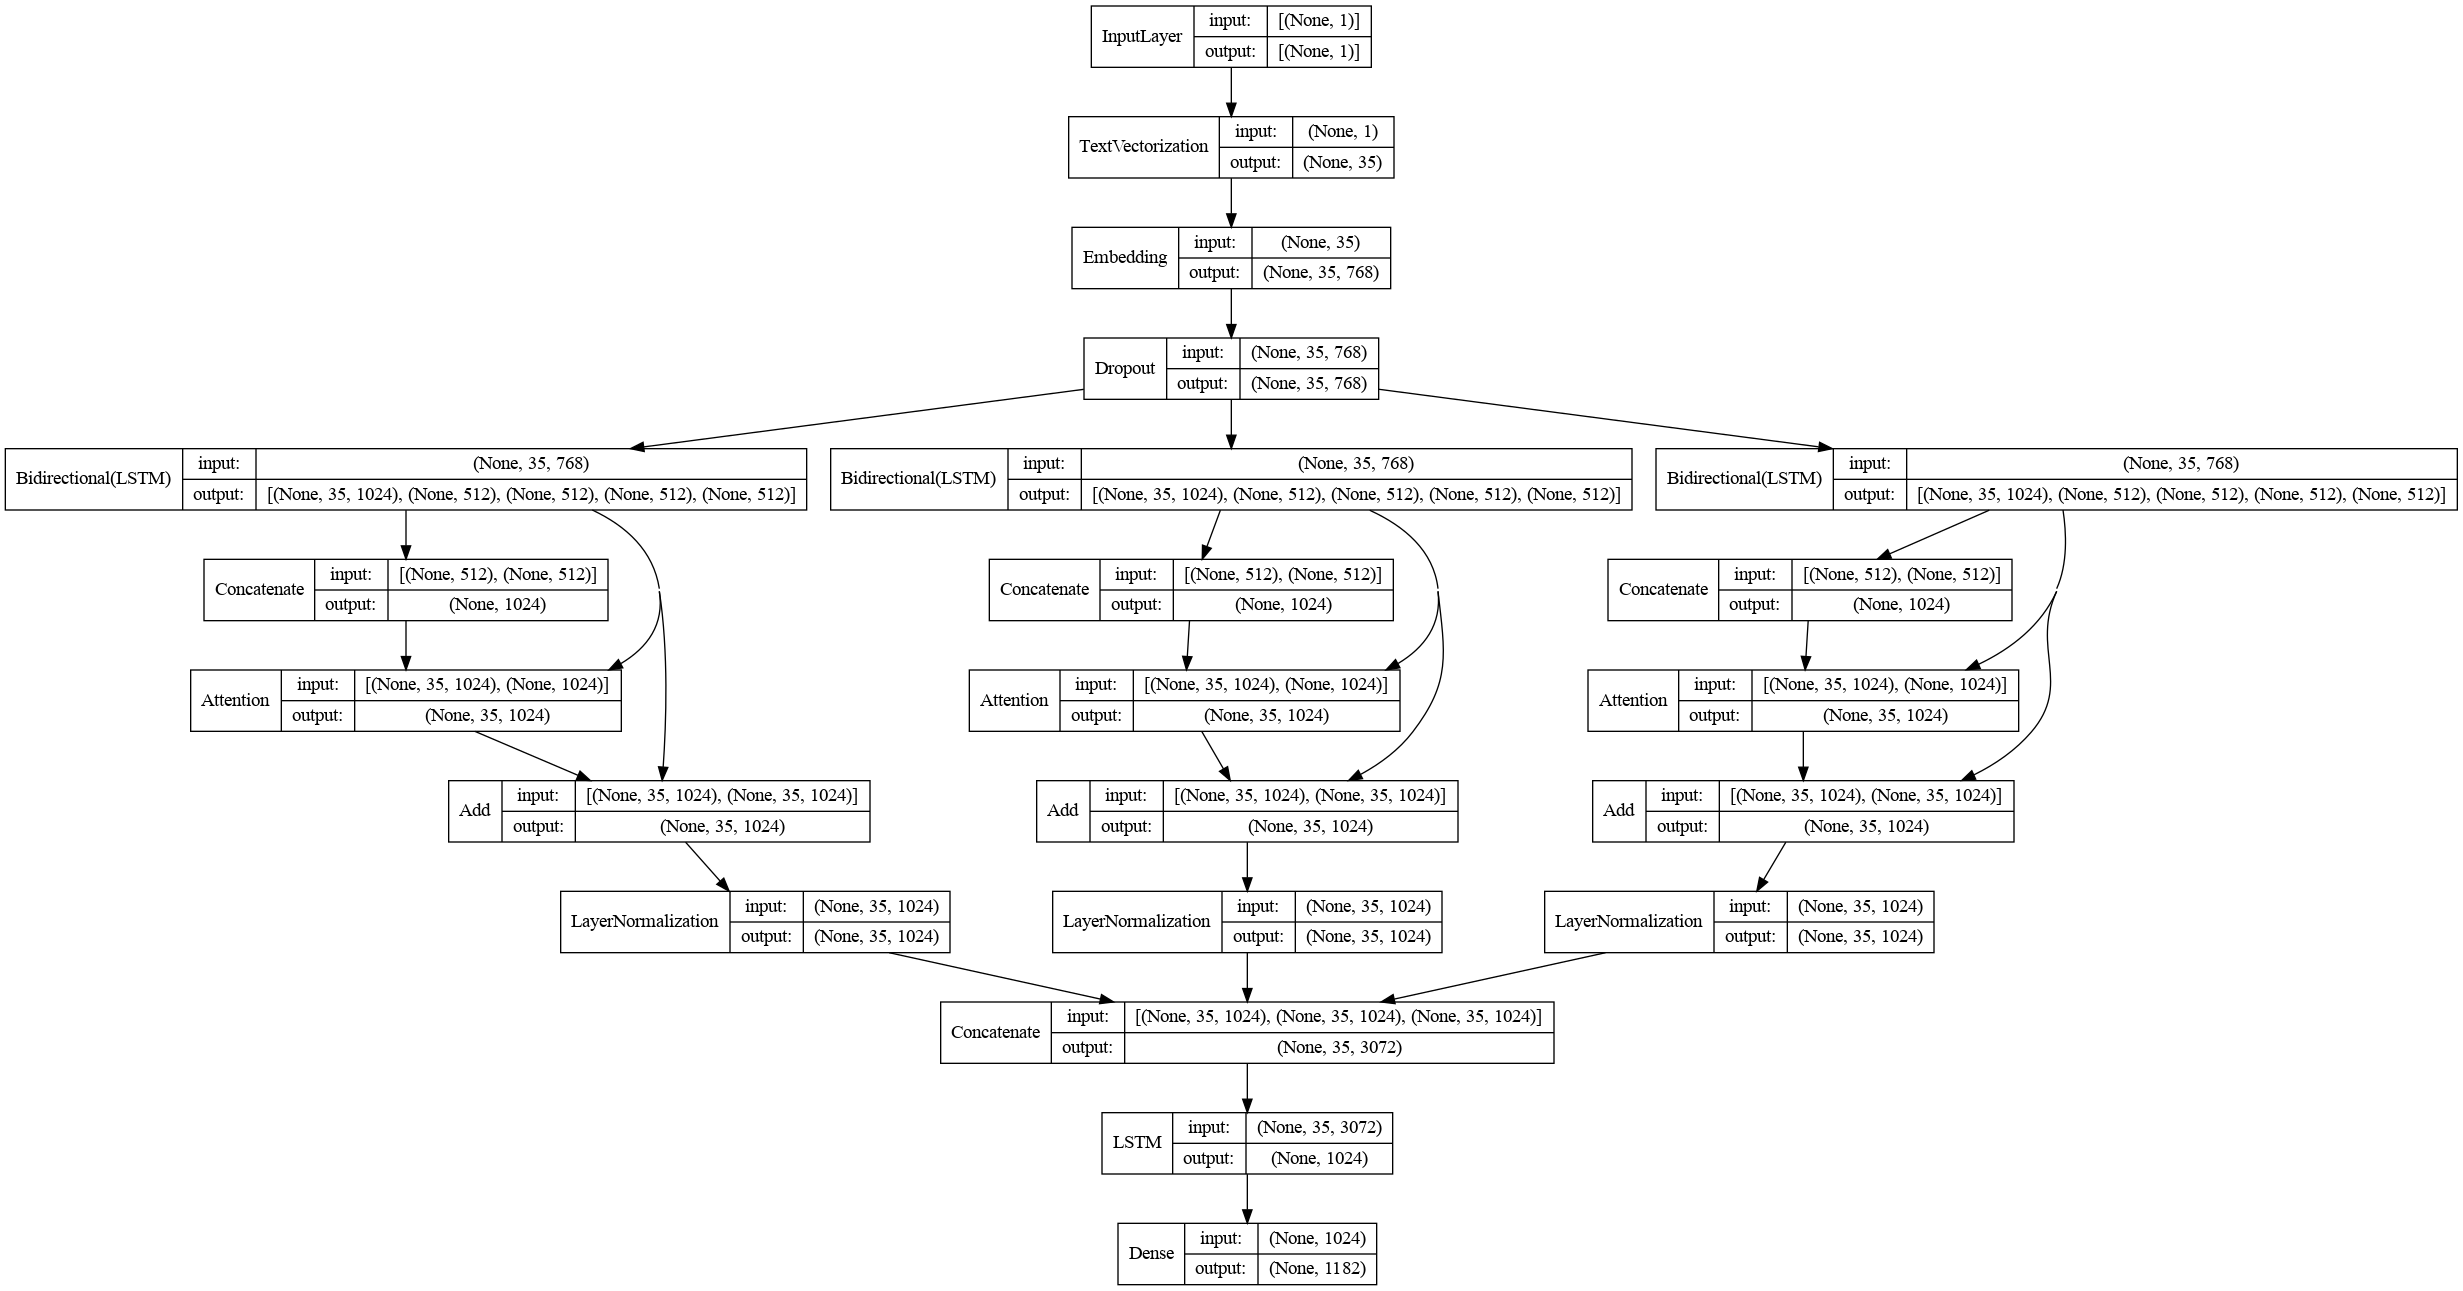

In [57]:
plot_model(LSTM_Dropout_SelfAttention_5, show_shapes=True, show_layer_names=False)

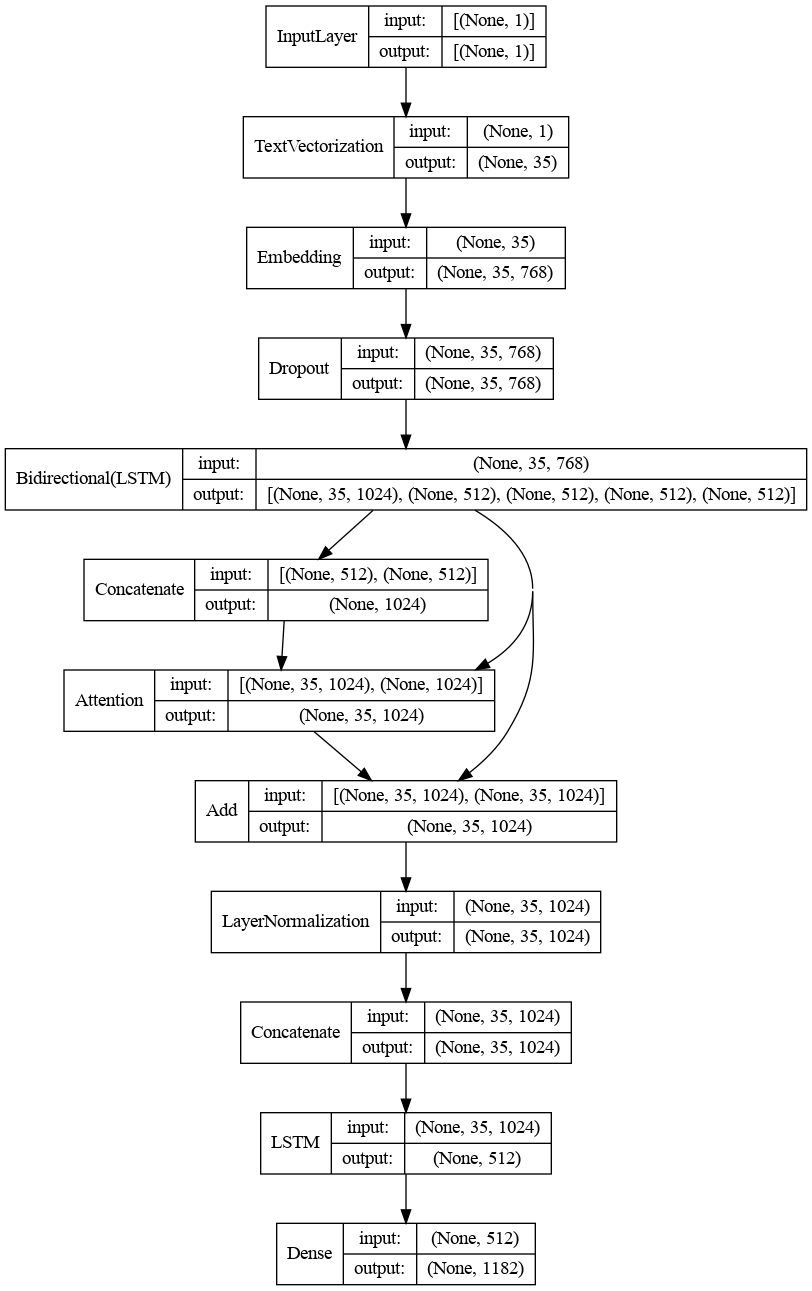

In [77]:
plot_model(LSTM_Dropout_SelfAttention_6, show_shapes=True, show_layer_names=False)

In [74]:
LSTM_Dropout_256 = load_model("models/LSTM_Dropout_256.keras")
LSTM_Dropout_SelfAttention_256 = load_model("models/LSTM_Dropout_SelfAttention_256.keras")
LSTM_Dropout_SelfAttention_2 = load_model("models/LSTM_Dropout_SelfAttention_2.keras")
LSTM_Dropout_SelfAttention_3 = load_model("models/LSTM_Dropout_SelfAttention_3.keras")
LSTM_Dropout_SelfAttention_4 = load_model("models/LSTM_Dropout_SelfAttention_4.keras")
LSTM_Dropout_SelfAttention_5 = load_model("models/LSTM_Dropout_SelfAttention_5.keras")

In [63]:
other_RNN_scores = {}
other_RNN_scores["LSTM_Dropout_256"] = calculate_scoring_metrics(LSTM_Dropout_256)
other_RNN_scores["LSTM_Dropout_SelfAttention_256"] = calculate_scoring_metrics(LSTM_Dropout_SelfAttention_256)
other_RNN_scores["LSTM_Dropout_SelfAttention_2"] = calculate_scoring_metrics(LSTM_Dropout_SelfAttention_2)
other_RNN_scores["LSTM_Dropout_SelfAttention_3"] = calculate_scoring_metrics(LSTM_Dropout_SelfAttention_3)
other_RNN_scores["LSTM_Dropout_SelfAttention_4"] = calculate_scoring_metrics(LSTM_Dropout_SelfAttention_4)
other_RNN_scores["LSTM_Dropout_SelfAttention_5"] = calculate_scoring_metrics(LSTM_Dropout_SelfAttention_5)

  0%|          | 0/151 [00:00<?, ?it/s]

  0%|          | 0/151 [00:00<?, ?it/s]

  0%|          | 0/151 [00:00<?, ?it/s]

  0%|          | 0/151 [00:00<?, ?it/s]

  0%|          | 0/151 [00:00<?, ?it/s]

  0%|          | 0/151 [00:00<?, ?it/s]

In [66]:
display_scores(other_RNN_scores)

{'LSTM_Dropout_256': {'mean_mistakes': 1.3311258278145695,
  'bleu': 0.07079834043360198},
 'LSTM_Dropout_SelfAttention_256': {'mean_mistakes': 1.3311258278145695,
  'bleu': 0.07079834043360198},
 'LSTM_Dropout_SelfAttention_2': {'mean_mistakes': 0.06622516556291391,
  'bleu': 0.8924302299008756},
 'LSTM_Dropout_SelfAttention_3': {'mean_mistakes': 1.7350993377483444,
  'bleu': 0.06819449140815095},
 'LSTM_Dropout_SelfAttention_4': {'mean_mistakes': 0.12582781456953643,
  'bleu': 0.9104681427386179},
 'LSTM_Dropout_SelfAttention_5': {'mean_mistakes': 0.10596026490066225,
  'bleu': 0.8790645805479381}}

In [67]:
simple_LSTM_256 = load_model("models/LSTM_256.keras")

In [75]:
objective_task(LSTM_Dropout_SelfAttention_2)

  0%|          | 0/10 [00:00<?, ?it/s]

['embrace each day is a canvas for it with kindness you to everyone',
 "radiate some and let it be the blessings in your life's",
 "believe that anything you to stones and heart singapore's skyline reaches",
 "life's actual purpose is a canvas paint it with vibrant experiences of dreams are",
 'dance through each and every of gratitude is a reminder of the world of moments',
 'let your time and energy the transform of your dreams and find their wings within',
 'every person is a ripple of kindness holds the potential to promise and',
 'our country singapore is a canvas paint it with vibrant experiences of dreams are',
 'planet earth is the universe for they hold the you of be a',
 'morning and evening would make it day with colors and gratitude you cherished are the symbol']

In [76]:
objective_task(simple_LSTM_256)

  0%|          | 0/10 [00:00<?, ?it/s]

['embrace each day purpose asia harmonious deepest harmonious asia culture stone wounded meaning',
 'radiate some asia asia culture radiates culture fortresses asia culture balance asia',
 'believe that weary weary adaptation weary adaptation fear fear fear fear fear',
 "life's actual purpose is harmonious not tales asia stone asia stone stone wounded meaning",
 'dance through each and every cornerstone culture stone wounded adaptation spoken stone wounded meaning fear',
 'let your time and energy canvases perfume perfume reach rich asia uncovered asia chaos kent',
 'every person is harmonious village harmonious village harmonious deepest guiding frontiers culture radiates',
 'our country singapore is harmonious tales asia stone wounded adaptation rainforests culture stone wounded',
 'planet earth is harmonious grace asia sunrise kent asia fear asia sunrise kent',
 'morning and evening would make it purpose esplanade soundtrack culture beat kent kent kent corner soundtrack']

In [ ]:
simple_GRU = Sequential([
    vectorize_layer,
    Embedding(total_words, 1000),
    # Flatten(),
    GRU(200, return_sequences=True),
    GRU(200),
    Dense(total_words, activation='softmax')
])

# simple_GRU = Sequential([
#     Embedding(total_words, 10000, input_length=max_sequence_length),
#     # Flatten(),
#     GRU(200, return_sequences=True),
#     GRU(200),
#     Dense(total_words, activation='softmax')
# ])

simple_GRU.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# history = model.fit(, epochs=50, verbose=1, batch_size=128, validation_data=(X_validation, y_validation))

history = fit_model(simple_GRU, "training_checkpoints/simple_GRU_weights.{epoch:02d}-{val_accuracy:.2f}.h5", batch_size=256, epochs=20)

In [316]:
simple_stacked = Sequential([
    vectorize_layer,
    Embedding(total_words, 1000),
    # Flatten(),
    RNN(StackedRNNCells([LSTMCell(32) for _ in range(2)])),
    # Dense(2000, activation="relu"),
    Dense(total_words, activation='softmax')
])

# simple_GRU = Sequential([
#     Embedding(total_words, 10000, input_length=max_sequence_length),
#     # Flatten(),
#     GRU(200, return_sequences=True),
#     GRU(200),
#     Dense(total_words, activation='softmax')
# ])

simple_stacked.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# history = model.fit(, epochs=50, verbose=1, batch_size=128, validation_data=(X_validation, y_validation))

history = fit_model(simple_stacked, "training_checkpoints/simple_GRU_weights.{epoch:02d}-{val_accuracy:.2f}.h5", batch_size=128, epochs=20)

Epoch 1/20
286/286 [==============================] - 84s 290ms/step - loss: 5.5659 - accuracy: 0.0687 - val_loss: 5.6089 - val_accuracy: 0.0885
Epoch 2/20
286/286 [==============================] - 78s 273ms/step - loss: 5.3031 - accuracy: 0.0726 - val_loss: 5.6810 - val_accuracy: 0.0885
Epoch 3/20
286/286 [==============================] - 77s 269ms/step - loss: 5.3010 - accuracy: 0.0743 - val_loss: 5.7247 - val_accuracy: 0.0628
Epoch 4/20
286/286 [==============================] - 77s 270ms/step - loss: 5.2998 - accuracy: 0.0731 - val_loss: 5.7522 - val_accuracy: 0.0628
Epoch 5/20
286/286 [==============================] - 78s 271ms/step - loss: 5.2989 - accuracy: 0.0727 - val_loss: 5.7772 - val_accuracy: 0.0628
Epoch 6/20
286/286 [==============================] - 79s 276ms/step - loss: 5.2979 - accuracy: 0.0758 - val_loss: 5.7843 - val_accuracy: 0.0885
Epoch 7/20
286/286 [==============================] - 80s 279ms/step - loss: 5.2980 - accuracy: 0.0732 - val_loss: 5.8095 - val_ac

KeyboardInterrupt: 

In [198]:
max_vocab_size = 10000

vectorize_layer = TextVectorization(
    max_tokens=max_vocab_size,
    output_mode='int',
    output_sequence_length=200
)

vectorize_layer.adapt([" ".join(x) for x in tokenized_quotes])

simple_LSTM = Sequential([
    vectorize_layer,
    Embedding(total_words, 100),
    # Flatten(),
    LSTM(200, return_sequences=True),
    LSTM(200),
    Dense(total_words, activation='softmax')
])


simple_LSTM.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
# history = model.fit(, epochs=50, verbose=1, batch_size=128, validation_data=(X_validation, y_validation))

history = fit_model(simple_LSTM, "training_checkpoints/simple_LSTM_weights.{epoch:02d}-{val_accuracy:.2f}.h5", batch_size=256, epochs=20)

Epoch 1/20
 49/241 [=====>........................] - ETA: 57s - loss: 5.6612 - accuracy: 0.0728

KeyboardInterrupt: 

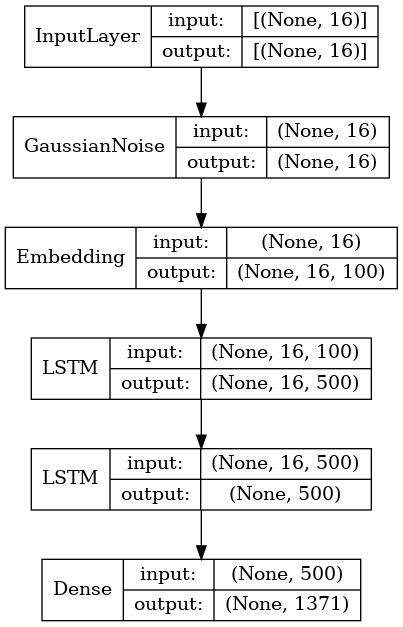

In [117]:
plot_model(simple_RNN, to_file='images/models/simple_LSTM.png', show_shapes=True, show_layer_names=False)

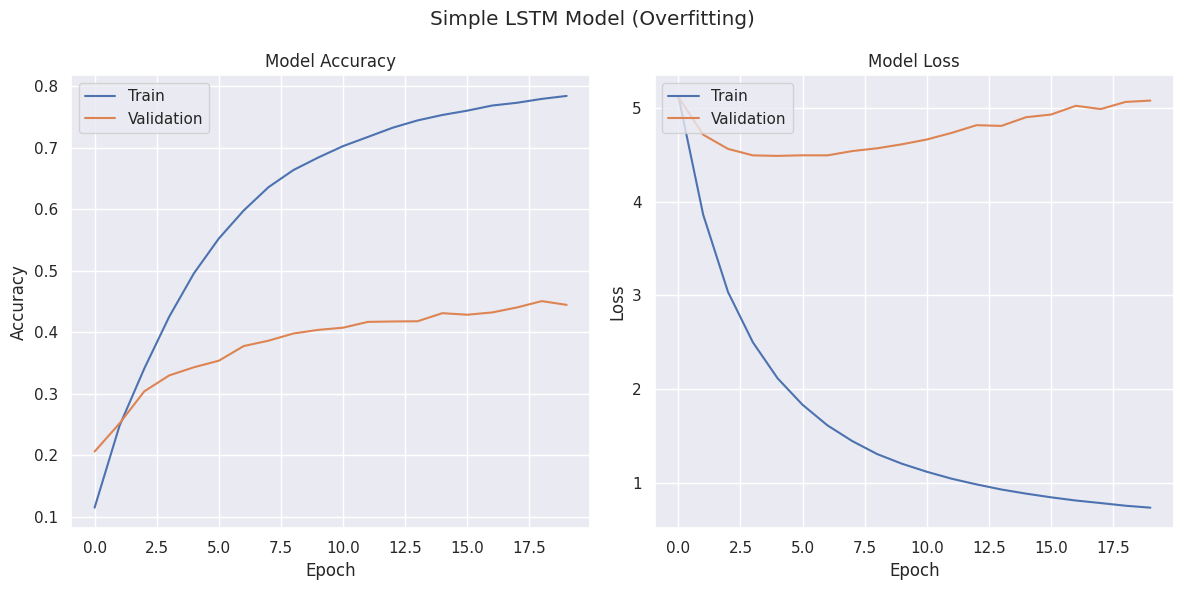

In [104]:
plot_history(history, "Simple LSTM Model (Overfitting)", "images/Simple LSTM Model (Overfitting).png")

* The model is unable to generalise and severely overfits on the training set.

In [45]:
# Attention is all you need

inputs = tf.keras.layers.Input(shape=(max_sequence_length,))
embedding_layer = Embedding(input_dim=total_words, output_dim=2000)(inputs)
lstm_layer = GRU(200, return_sequences=True)(embedding_layer)

attention = Attention(use_scale=True)([lstm_layer, lstm_layer])
context_vector = tf.reduce_sum(attention * lstm_layer, axis=1)

output = Dense(total_words, activation='softmax')(context_vector)

attention_model = Model(inputs=inputs, outputs=output)

attention_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = fit_model(attention_model, "training_checkpoints/simple_RNN_weights.{epoch:02d}-{val_accuracy:.2f}.hdf5", epochs=50)

Epoch 1/50
153/153 [==============================] - ETA: 0s - loss: 5.6172 - accuracy: 0.0888
Epoch 1: val_loss improved from inf to 5.49605, saving model to training_checkpoints/simple_RNN_weights.01-0.09.hdf5
153/153 [==============================] - 4s 23ms/step - loss: 5.6172 - accuracy: 0.0888 - val_loss: 5.4960 - val_accuracy: 0.0930
Epoch 2/50
153/153 [==============================] - ETA: 0s - loss: 5.0289 - accuracy: 0.1218
Epoch 2: val_loss improved from 5.49605 to 5.24764, saving model to training_checkpoints/simple_RNN_weights.02-0.14.hdf5
153/153 [==============================] - 2s 12ms/step - loss: 5.0289 - accuracy: 0.1218 - val_loss: 5.2476 - val_accuracy: 0.1417
Epoch 3/50
153/153 [==============================] - ETA: 0s - loss: 4.5129 - accuracy: 0.1549
Epoch 3: val_loss improved from 5.24764 to 5.01739, saving model to training_checkpoints/simple_RNN_weights.03-0.18.hdf5
153/153 [==============================] - 2s 11ms/step - loss: 4.5129 - accuracy: 0.1549

KeyboardInterrupt: 

In [ ]:
attention_model.summary()